In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import nltk
import re
import spacy
from spacy.lang.en import English
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora
import pickle
import gensim
import pyLDAvis.gensim
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

import glob
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

from sklearn.naive_bayes import MultinomialNB
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from nltk.probability import FreqDist

ModuleNotFoundError: No module named 'spacy'

In [215]:
# To update 

#nltk.download('stopwords')
#nltk.download('wordnet')


# Steps for Preprocessing

1. Tokenize text - split up by word
2. Remove stopwords
3. Lemmatize to get the root word

# About the Data

- No quantitative features! We can consider some by aggregating by categories later.

# Limitations

- Inconsistency in which features are included. There are many null values throughout the data
- Very inconsistent/sparse Salary column 

### Merging separate data files (only for indeed for now)

In [3]:
df_main = pd.DataFrame()

files = glob.glob('data_raw' + "/indeed*.csv")
# files = glob.glob('data' + "/*.csv")

for i,file in enumerate(files):
    df = pd.read_csv(file)
    m = re.search(r'/\w*\W*\d\W\d', file)
    filename= m.group()
    search_date = filename[len(filename)-3:len(filename)]
    platform = re.search(r'\w+', filename).group()
    
    df['platform'] = len(df)*[platform]
    df['search_date'] = len(df)*[search_date]
    
    frames = [df_main, df]
    df_main = pd.concat(frames)

    
    #print(this_file)
    #values.append((list(df.iloc[len(df)-1,].values)))
    #keys = keys + int(len(df)+1)
    #print(list(df.iloc[len(df)-1,].values))
    

    #keys.append(file[12:17])
    #print(file[12:17])
    #values.append((list(this_file.iloc[len(this_file)-1,].values)))
#keys = list(range(keys))

In [4]:
df = df_main
df.isnull().sum()

company          54
location          0
title             0
post_date        46
salary         2332
description       1
url               0
search_role       0
platform          0
search_date       0
dtype: int64

In [5]:
# Look for the one null value in description column

df[df['description'].isnull()].index

Int64Index([328], dtype='int64')

In [6]:
'''Drop the row that has null value in description'''

df = df.dropna(subset=['description'])

In [7]:
df.isnull().sum()


company          53
location          0
title             0
post_date        45
salary         2331
description       0
url               0
search_role       0
platform          0
search_date       0
dtype: int64

In [7]:
df.head()

company            location  \
0                      Noom Inc.        New York, NY   
1  Strategic Financial Solutions  New York, NY 10018   
2                        Averity        New York, NY   
3              Lenmar Consulting  Woodcliff Lake, NJ   
4       Memorial Sloan Kettering  New York, NY 10017   

                                               title post_date  \
0                                     Data Engineer        30+   
1                               Lead Data Scientist         18   
2                             Manager, Data Science         12   
3                            Medical Data Scientist          0   
4  Sr Strategic Consultant / Data Scientist (Pati...        16   

                       salary  \
0                         NaN   
1                         NaN   
2  $175,000 - $225,000 a year   
3                 $75 an hour   
4                         NaN   

                                         description  \
0   \n At Noom, we use scientifically proven meth...   
1   \n Overview\nDo you love numbers and finding ...   
2   \n We are one of the world's premiere travel ...   
3   \n Medical Data Scientist \n Must have at lea...   
4   \n <h2 class="jobSectionHeader">Company Overv...   

                                                 url     search_role platform  \
0  https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...  Data Scientist   indeed   
1  https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...  Data Scientist   indeed   
2  https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...  Data Scientist   indeed   
3  https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...  Data Scientist   indeed   
4  https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...  Data Scientist   indeed   

  search_date  
0         8-5  
1         8-5  
2         8-5  
3         8-5  
4         8-5

In [8]:
# Create English parser
#spacy.load('en')
parser = English()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('\n'):
            continue
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [9]:
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
        print(lemma)
    
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [10]:
# List of stopwords to upload
en_stop = set(nltk.corpus.stopwords.words('english'))


In [11]:
desc_tokens = []

for index, row in df.iterrows():    
    tokens = tokenize(row['description'])
    #print(index)
    # Filters tokens to only words of length 4 or more
    tokens = [token for token in tokens if len(token) > 4]
    # Filters tokens that are in list of stopwords
    tokens = [token for token in tokens if token not in en_stop]
    # Lemmatizes tokens to their roots
    tokens = [get_lemma(token) for token in tokens]
    desc_tokens.append(tokens)

df['desc_tokens'] = desc_tokens

/Users/ckato/Documents/GitHub/MARi-topic-modeling/venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
df

company             location  \
0                             Noom Inc.         New York, NY   
1         Strategic Financial Solutions   New York, NY 10018   
2                               Averity         New York, NY   
3                     Lenmar Consulting   Woodcliff Lake, NJ   
4              Memorial Sloan Kettering   New York, NY 10017   
5                            Digitalogy         New York, NY   
6                                Viacom   New York, NY 10036   
7                     Butterfly Network         New York, NY   
8                               Celonis   New York, NY 10036   
9                                Macy's   New York, NY 10001   
10                          Squarespace   New York, NY 10014   
11           Remedy BPCI Partners, LLC.         New York, NY   
12                         Getty Images         New York, NY   
13                      Remedy Partners         New York, NY   
14                            Quantilus   New York, NY 10036   
15                             TRANZACT   Fort Lee, NJ 07024   
16                                 81qd   New York, NY 10017   
17                                Apple          Seattle, WA   
18                            eBay Inc.   Bellevue, WA 98009   
19                        Akvelon, Inc.          Redmond, WA   
20                        Akvelon, Inc.   Bellevue, WA 98004   
21          Centrica Business Solutions   Bellevue, WA 98004   
22                                Tesla          Seattle, WA   
23                       Neal Analytics          Redmond, WA   
24                            Starbucks    Seattle, WA 98148   
25                            Microsoft   Bellevue, WA 98004   
26            Amazon.com Services, Inc.          Seattle, WA   
27                            Starbucks    Seattle, WA 98134   
28                        Expedia Group   Bellevue, WA 98004   
29                            Starbucks    Seattle, WA 98134   
..                                  ...                  ...   
100               Washington County, OR        Hillsboro, OR   
101                                BBSI  Vancouver, WA 98662   
102                   CU Business Group   Portland, OR 97220   
103                                 NaN       Ridgefield, WA   
104       Motus Recruiting and Staffing   Portland, OR 97204   
105                         Umpqua Bank   Portland, OR 97258   
106                   City of Vancouver  Vancouver, WA 98660   
107                    CareOregon, Inc.         Portland, OR   
108        Viewpoint, a Trimble Company         Portland, OR   
109            City of Hillsboro Oregon  Hillsboro, OR 97123   
110                         Umpqua Bank   Portland, OR 97258   
111                          PacifiCorp   Portland, OR 97213   
112          Lattice Semiconductor Corp  Hillsboro, OR 97124   
113                          PacifiCorp   Portland, OR 97232   
114     First Tech Federal Credit Union  Hillsboro, OR 97124   
115              Arnerich Massena, Inc.         Portland, OR   
116            Child and Family Service       ‘Ewa Beach, HI   
117                  Kamehameha Schools   Honolulu, HI 96813   
118                                SOSi        United States   
119               American Savings Bank   Honolulu, HI 96817   
120                 Booz Allen Hamilton     Fort Shafter, HI   
121                      Bank of Hawaii      Oahu Island, HI   
122                                 NaN         Honolulu, HI   
123  Hawaii Medical Service Association   Honolulu, HI 96814   
124                 First Hawaiian Bank         Honolulu, HI   
125                 First Hawaiian Bank         Honolulu, HI   
126           Hawaiian Electric Company      Oahu Island, HI   
127                                 NaN         Honolulu, HI   
128                                 NaN     Fort Shafter, HI   
129                                 NaN        United States   

                                                 title post_dat

## To Bin By Search Keyword
Explanation--
I decided to bin the data by the search_role column, as this column will give more consistent results compared to the actual job title postings. 

#### For further analysis, I will take a subset of the data by *ACTUAL* postings that have the title of "data scientist" and "data analyst" that I am looking for.


A few research questions to consider: 
- What is the difference between data scientist roles and data analyst roles.
- Are more data science roles incorporating more software engineering aspects? (as described in ____)
- Which areas/skills are more important? And what subjects/major to focus on in school? -- (ie: computer science/ statistics/ business)
- Is grad school necessary



In [12]:
by_role = df.groupby('search_role')
by_city = df.groupby('location')

In [19]:
for key, item in by_role:
    print(key)
    print(item['title'])

Artificial Intelligence Researcher
771                                  Content Specialist 
772                            Computational Researcher 
773                             Research Scientist (AI) 
774                   Alternative Data Research Analyst 
775                                      Research Intern
776                              Research Engineer (AI) 
777    Research Scientist, Machine Learning and Intel...
778                                     Research Intern 
779                             Visiting Scientist (AI) 
780                                  Research Scientist 
781                          Associate Research Manager 
782                                        Writer/Editor
783                          Applied Research Scientist 
784    Full Time Opportunities for PhD Students or Re...
785    Internship Opportunities for PhD Students: Res...
786            Director of Machine Learning Engineering 
787                                     Research Inte

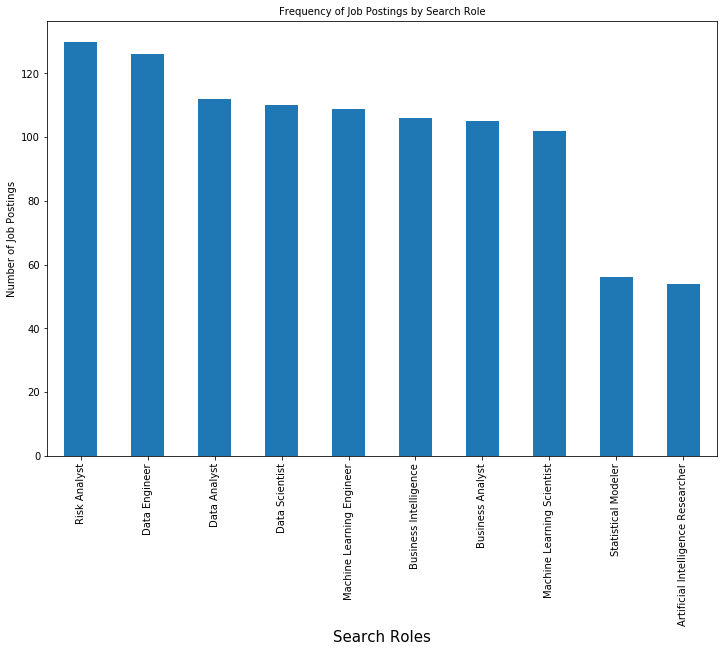

In [35]:
plt.figure(figsize=(12,8))
by_role.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Search Roles", fontsize=15)
plt.ylabel("Number of Job Postings",fontsize=10)
plt.title("Frequency of Job Postings by Search Role", fontsize=10)
plt.xticks(rotation=90)
plt.show()

## Add preprocessing for original search_city 
to run similar visualization as above. 
To create bar plots of CITY x search role

## Add visualization of just data scientist and data analyst roles. 
Search frequency / bar plot by city



# Frequency Distributions



Search Role:  Artificial Intelligence Researcher
[('research', 441), ('experience', 287), ('learning', 157), ('machine', 147), ('include', 144)]


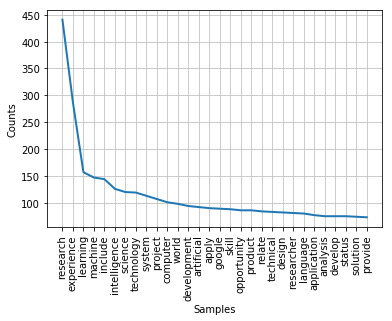

<Figure size 3600x1440 with 0 Axes>


Search Role:  Business Analyst
[('business', 796), ('experience', 404), ('process', 290), ('project', 279), ('skill', 260)]


<Figure size 3600x1440 with 0 Axes>


Search Role:  Business Intelligence
[('business', 605), ('experience', 550), ('intelligence', 300), ('skill', 276), ('include', 207)]


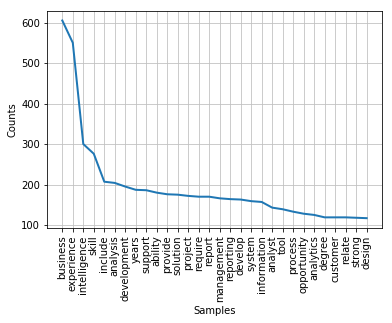

<Figure size 3600x1440 with 0 Axes>


Search Role:  Data Analyst
[('experience', 410), ('business', 309), ('analysis', 249), ('skill', 245), ('include', 232)]


<Figure size 3600x1440 with 0 Axes>


Search Role:  Data Engineer
[('experience', 595), ('system', 253), ('business', 247), ('years', 238), ('engineer', 232)]


<Figure size 3600x1440 with 0 Axes>


Search Role:  Data Scientist
[('experience', 578), ('business', 309), ('science', 299), ('learning', 275), ('analysis', 223)]


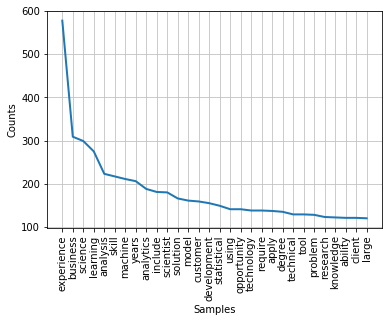

<Figure size 3600x1440 with 0 Axes>


Search Role:  Machine Learning Engineer
[('learning', 570), ('experience', 529), ('machine', 459), ('technology', 246), ('engineer', 199)]


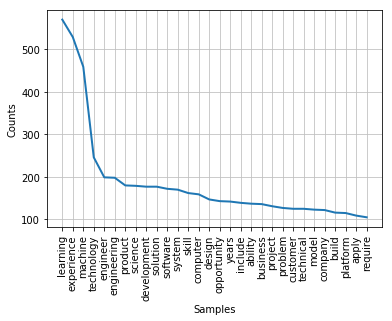

<Figure size 3600x1440 with 0 Axes>


Search Role:  Machine Learning Scientist
[('experience', 552), ('learning', 545), ('machine', 453), ('science', 254), ('business', 231)]


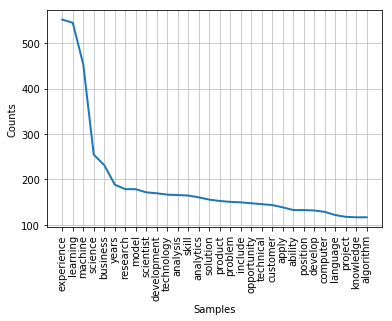

<Figure size 3600x1440 with 0 Axes>


Search Role:  Risk Analyst
[('experience', 492), ('management', 457), ('business', 404), ('include', 291), ('skill', 290)]


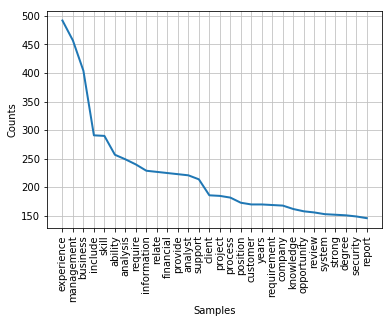

<Figure size 3600x1440 with 0 Axes>


Search Role:  Statistical Modeler
[('business', 251), ('experience', 242), ('model', 236), ('modeling', 153), ('skill', 146)]


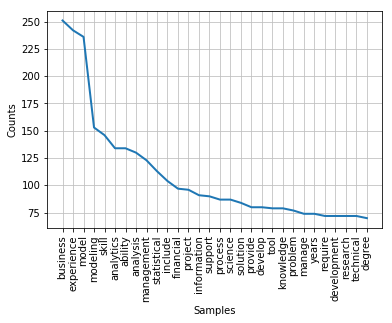

<Figure size 3600x1440 with 0 Axes>

In [271]:
# Preprocessing grouped (by search role) 

grouped_tokens = []

for i, merged_text in enumerate(descriptions):
    print('Search Role: ', roles[i])
    tokens = tokenize(merged_text)
    # Filters tokens to only words of length 4 or more
    tokens = [token for token in tokens if len(token) > 4]
    # Filters tokens that are in list of stopwords
    tokens = [token for token in tokens if token not in en_stop]
    # Lemmatizes tokens to their roots
    tokens = [get_lemma(token) for token in tokens]
    grouped_tokens.append(tokens)
    
    fdist = FreqDist(tokens)
    print(fdist.most_common(5))
    
    fdist.plot(30,cumulative=False )
    plt.figure(figsize=(50, 20))  # the size you want

    plt.show()
    print()
    

In [ ]:
fdist = FreqDist(tokenized_word)
print(fdist)

## Wordclouds by Role

In [111]:
# List of roles and frequency
by_role.size().sort_values(ascending=False)


search_role
Risk Analyst                          130
Data Engineer                         126
Data Analyst                          112
Data Scientist                        110
Machine Learning Engineer             109
Business Intelligence                 106
Business Analyst                      105
Machine Learning Scientist            102
Statistical Modeler                    56
Artificial Intelligence Researcher     54
dtype: int64

In [14]:
def group_descriptions(by_role):
    '''Creates concatenated/joined text for job descriptions for each search role'''
    roles = []
    merged_desc = []
    for key, items in by_role.indices.items():        
        
        # concatenate strings in descriptions column (by search_role grouping) and append to list of merged descriptions
        string=(" ").join(description for description in df.iloc[items,5])
        merged_desc.append(string)
        
        roles.append(key)

    return merged_desc, roles


descriptions, roles = group_descriptions(by_role)

#listed_descriptions = list(df.iloc[items,5])


Search Role:  Artificial Intelligence Researcher


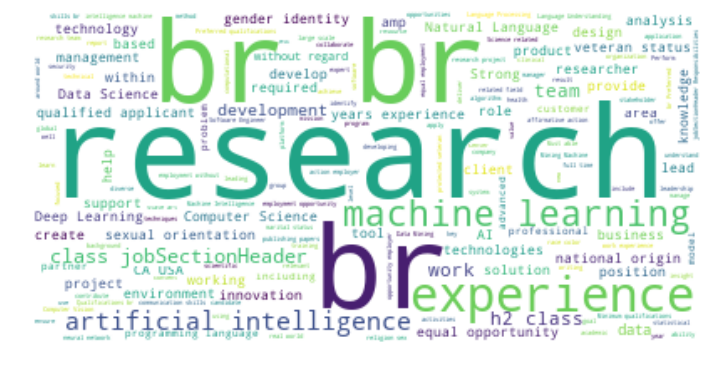

Search Role:  Business Analyst


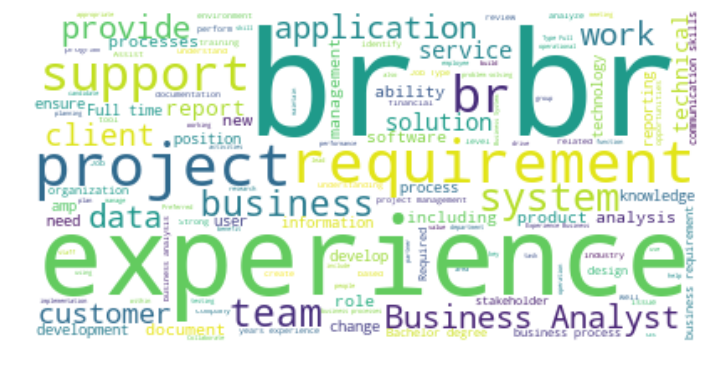

Search Role:  Business Intelligence


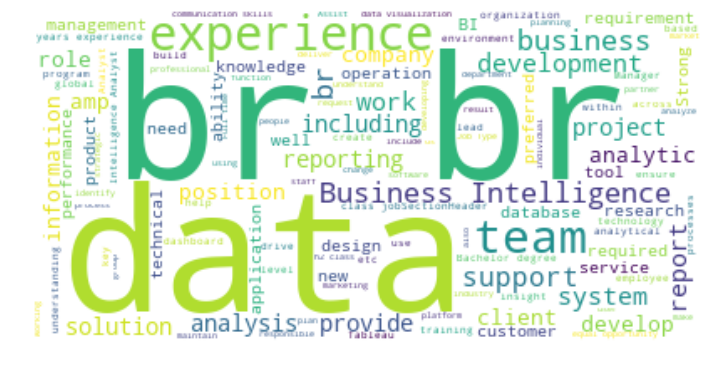

Search Role:  Computer Vision Engineer


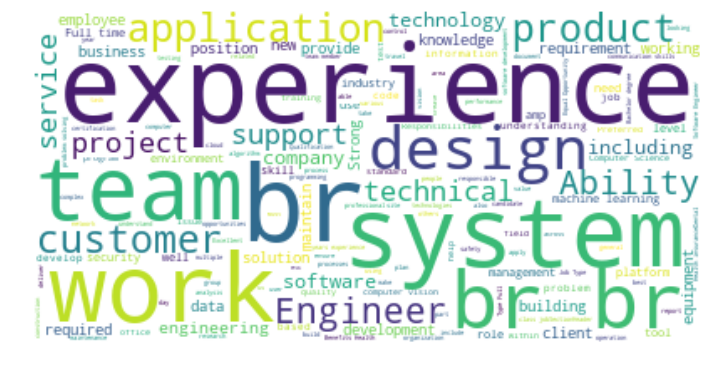

Search Role:  Data Analyst


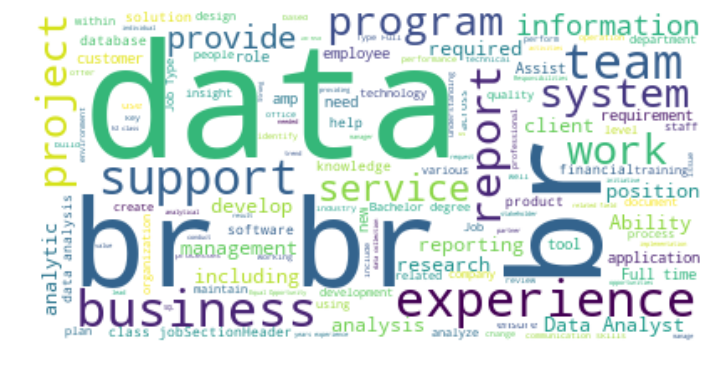

Search Role:  Data Engineer


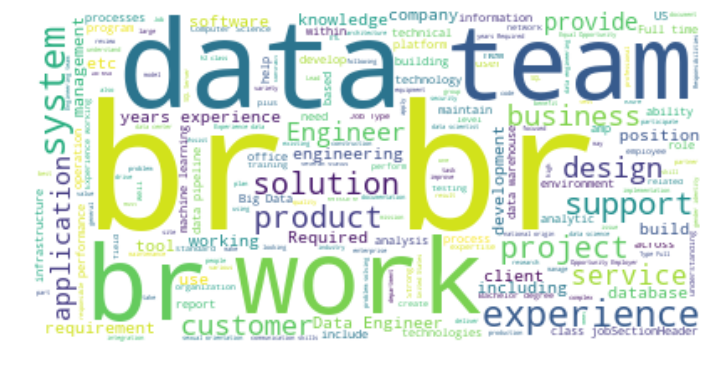

Search Role:  Data Scientist


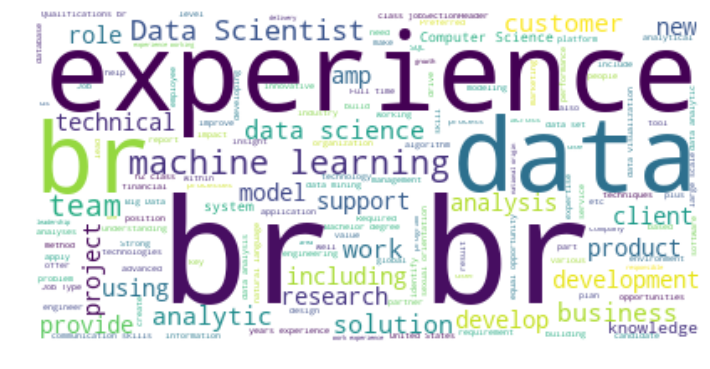

Search Role:  Full Stack Engineer


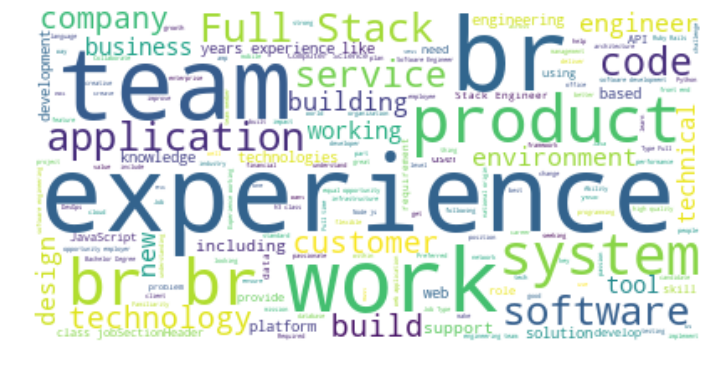

Search Role:  ML Engineer


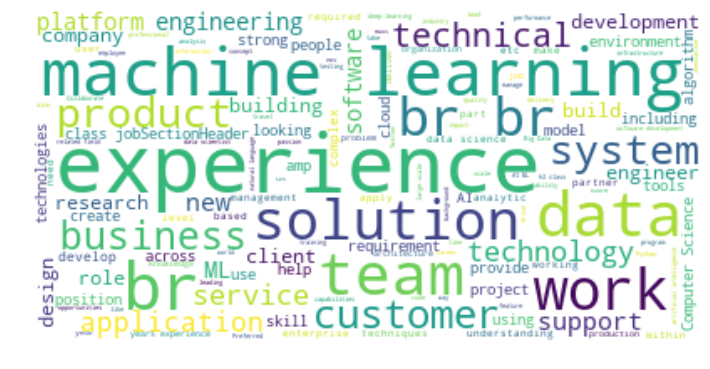

Search Role:  Machine Learning Engineer


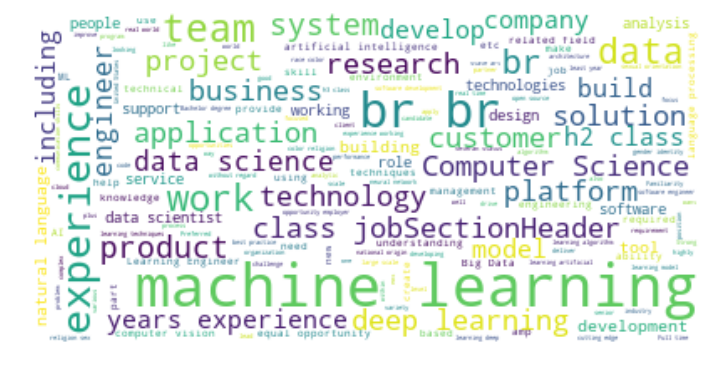

Search Role:  Machine Learning Scientist


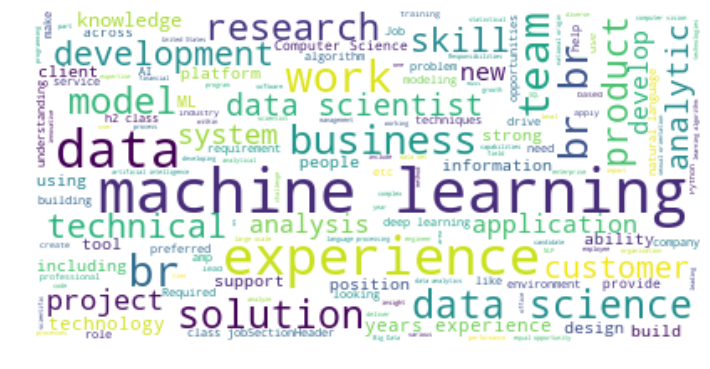

Search Role:  Research Intern


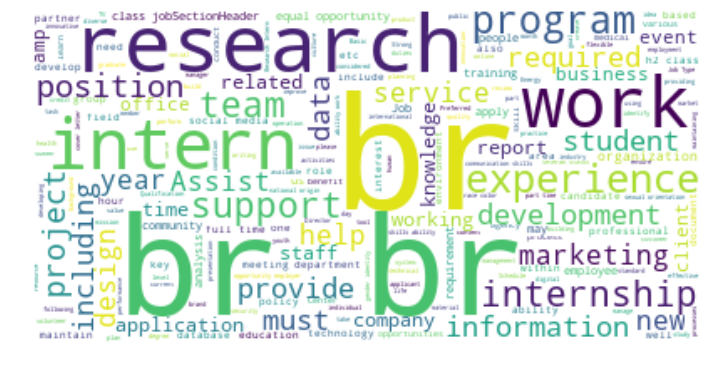

Search Role:  Researcher


Search Role:  Risk Analyst


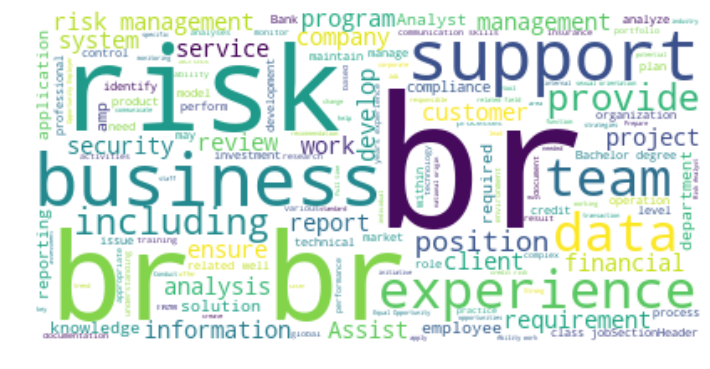

Search Role:  Software Engineer


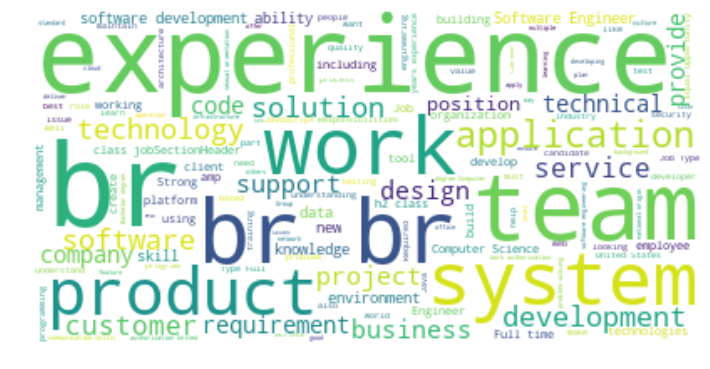

Search Role:  Statistical Modeler


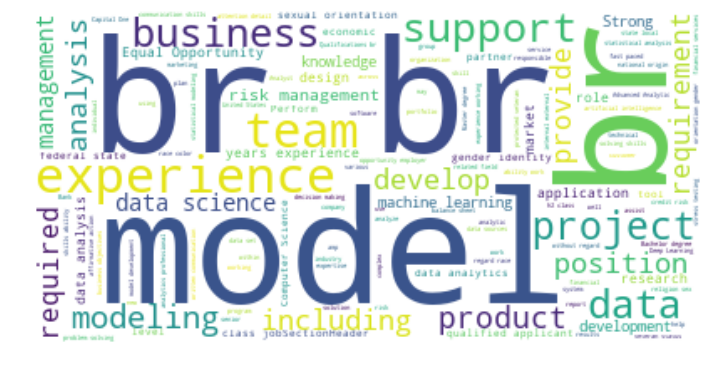

In [283]:
def create_wordcloud(text):
    # Start with one review:
    #text = descriptions[0]

    # Create and generate a word cloud image:
    wordcloud = WordCloud(stopwords = en_stop, background_color='white').generate(text)

    # Display the generated image:
    plt.figure( figsize=(12,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    
    plt.axis("off")
    plt.show()
    

    
for i, merged_text in enumerate(descriptions):
    print('Search Role: ', roles[i])
    create_wordcloud(merged_text)

### LDA With Gensim

list of tokens -> bag-of-words corpus -> dictionary -> bag-of-words corpus -> LDA model



from LDA model -> extract top topics

In [25]:
# Create a dictionary from the data
dictionary = corpora.Dictionary(desc_tokens)

# Create a bag-of-words corpus 
# also called corpus! 
doc_term_matrix = [dictionary.doc2bow(text) for text in desc_tokens]

In [27]:
pickle.dump(corpus, open('corpus.pkl', 'wb'))
#dictionary.save('dictionary.gensim')

Documentation

https://radimrehurek.com/gensim/models/ldamodel.html

## Topic modeling over all descriptions

In [28]:

NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
#ldamodel.save('model5.gensim')

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)
    
    

(0, '0.031*"learning" + 0.026*"machine" + 0.025*"experience" + 0.013*"computer"')
(1, '0.010*"insurance" + 0.009*"management" + 0.009*"experience" + 0.009*"client"')
(2, '0.016*"experience" + 0.015*"system" + 0.014*"business" + 0.011*"project"')
(3, '0.022*"experience" + 0.013*"product" + 0.010*"engineer" + 0.010*"software"')
(4, '0.012*"intern" + 0.010*"internship" + 0.009*"include" + 0.009*"program"')
(5, '0.011*"management" + 0.011*"ability" + 0.011*"financial" + 0.010*"experience"')
(6, '0.021*"business" + 0.015*"experience" + 0.009*"analytics" + 0.008*"skill"')
(7, '0.021*"experience" + 0.015*"software" + 0.013*"technology" + 0.013*"development"')
(8, '0.033*"research" + 0.009*"experience" + 0.009*"health" + 0.009*"position"')
(9, '0.018*"zillow" + 0.016*"estate" + 0.012*"fortune" + 0.011*"workplace"')


## Determining Optimum Number of Topics to Use
### And coherence measurements

As seen on
https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [56]:
def compute_coherence_values(dictionary, doc_term_matrix, desc_tokens, stop, start=2, step=3):
    """
    From: https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSi model on range of num_topics 
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=desc_tokens, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [57]:
def plot_graph(desc_tokens,start, stop, step, dictionary, doc_term_matrix):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,desc_tokens,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.figure(figsize=(10,7))
    plt.plot(x, coherence_values)
    plt.title('Coherence Score to Assess Number of Topics')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.show()

In [60]:

start,stop,step=2,12,1
plot_graph(desc_tokens,start,stop,step, dictionary, doc_term_matrix)

#### Results: 
Optimal number of topics to evaluate is 3

In [20]:
NUM_TOPICS = 3
ldamodel = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
#ldamodel.save('model5.gensim')

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)
# Create new model using different data set

(0, '0.012*"business" + 0.011*"experience" + 0.009*"skill" + 0.009*"management"')
(1, '0.016*"experience" + 0.008*"company" + 0.007*"software" + 0.007*"system"')
(2, '0.021*"experience" + 0.010*"learning" + 0.009*"technology" + 0.008*"business"')


# pyLDAvis

In [23]:
#dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
#lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')


In [30]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/ckato/Documents/GitHub/MARi-topic-modeling/venv/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# Text Classification Model
### Using Multinomial Naive Bayes Classification from scikit-learn

As seen on: 
https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk

The following model uses the one-hot-encoded description column in the data frame as the set of X features and evaluates the searched role as the response y variable. 

## 1. Using TF-IDF


In [243]:

vectorizer = TfidfVectorizer()

# generate matrix of word vectors 
tfidf_matrix = vectorizer.fit_transform(descriptions)

print(tfidf_matrix)

  (0, 14940)	0.08239122008492983
  (0, 1460)	0.05572518204914341
  (0, 6728)	0.0030768505425907405
  (0, 6164)	0.0075211902152218105
  (0, 13938)	0.015042380430443621
  (0, 3440)	0.005469956520161317
  (0, 12948)	0.00041047603120061355
  (0, 7097)	0.23589187493195676
  (0, 9882)	0.07999811410735926
  (0, 9341)	0.03828969564112922
  (0, 15211)	0.005469956520161317
  (0, 9503)	0.004119018103488565
  (0, 9608)	0.0034187228251008226
  (0, 8324)	0.007179317932711728
  (0, 5993)	0.11726219290095823
  (0, 10081)	0.004102467390120987
  (0, 15165)	0.004716366731527233
  (0, 1271)	0.6293868721010615
  (0, 11757)	0.016380984458015866
  (0, 15021)	0.015384252712953702
  (0, 15043)	0.059485777156754314
  (0, 3688)	0.01059804075781255
  (0, 3130)	0.0006837445650201646
  (0, 9366)	0.0013754211903497687
  (0, 1798)	0.0016472799395632468
  :	:
  (9, 13978)	0.0008829921854339337
  (9, 14507)	0.0008829921854339337
  (9, 11957)	0.0008829921854339337
  (9, 6884)	0.0017659843708678674
  (9, 8352)	0.00088299

In [259]:
tf=TfidfVectorizer()
text_tf= tf.fit_transform(df['description'])

# Build the training and sets using the one-hot-encoded TF-IDF vectorizer
X_train, X_test, y_train, y_test = train_test_split(
    text_tf, df['search_role'], test_size=0.3, random_state=1)

clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.3665480427046263


## 2. Using Bag of Words


In [256]:
# You can generate document term matrix by using scikit-learn's CountVectorizer.
#tokenizer to remove unwanted elements from out data like symbols and numbers
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(df['description'])


X_train, X_test, y_train, y_test = train_test_split(
    text_counts, df['search_role'], test_size=0.3, random_state=1)

clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.534994068801898


In [19]:
# for trigram model

cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (3,3),tokenizer = token.tokenize)
text_counts= cv.fit_transform(df['description'])

X_train, X_test, y_train, y_test = train_test_split(
    text_counts, df['search_role'], test_size=0.3, random_state=1)

clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.4531435349940688


# Word Similarity Between Aggregated Posts Grouped by Search Role



In [17]:
# load model and create Doc object

nlp = spacy.load('en_core_web_sm')


for i, merged_text in enumerate(descriptions):
    doc = nlp(merged_text)


    for token1 in doc:
        for token2 in doc:
            print(token1.text, token2.text, token1.similarity(token2))
            print()
        #print(token.vector)

 
   
  1.0

 
  We 0.047632378

 
  are 0.07642141

 
  hiring -0.041620012

 
  a -0.06454392

 
  full 0.03736029

 
  time 0.29213044

 
  Content 0.24647856

 
  Specialist 0.3880444

 
  in -0.034598656

 
  our -0.010847878

 
  New 0.32718158

 
  York 0.31792492

 
  , -0.028954929

 
  NY 0.31415328

 
  office 0.24499857

 
  . 0.14831832

 
  We 0.017472344



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  are 0.03425815

 
  looking -0.06832463

 
  for -0.03647995

 
  a -0.10171413

 
  passionate 0.10302919

 
  writer 0.17490225

 
  and -0.04767908

 
  researcher 0.13258909

 
  who -0.1537345

 
  will -0.05512592

 
  create 0.051080752

 
  compelling -0.041696325

 
  content -0.022048583

 
  for -0.13500014

 
  niche 0.22331382

 
  B2B 0.33843338

 
  & -0.07777076



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  amp 0.2801751

 
  ; 0.044100214

 
  technology 0.19617063

 
  industries 0.13189812

 
  . 0.08800123

 
  This -0.044482213

 
  includes -0.17016289

 
  articles 0.3756514

 
  , -0.017275706

 
  website 0.14428206

 
  copy 0.26224637

 
  , -0.01393264

 
  homepage 0.068487614

 
  copy 0.32305485

 
  , -0.055042095

 
  ad 0.22265759

 
  copy 0.27444637



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , -0.11170976

 
  solution 0.041741554

 
  sheets 0.19120128

 
  , -0.013641278

 
  info 0.29042992

 
  sheets 0.19067615

 
  , 0.006702476

 
  and 0.03522297

 
  email 0.17786704

 
  copy 0.27546808

 
  . 0.13565989

 
  
 0.13763808

 
  All -0.05485784

 
  content 0.065999515

 
  creation 0.20652439

 
  should -0.07667914

 
  be -0.0368299

 
  well 0.10219598



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  researched -0.12474029

 
  , -0.032816976

 
  so -0.09818007

 
  our -0.059615586

 
  ideal -0.0068824543

 
  candidate 0.13330652

 
  should -0.044288132

 
  have -0.0917057

 
  experience 0.012483864

 
  conducting -0.11041766

 
  interviews 0.30937448

 
  with -0.011366391

 
  clients 0.2671393

 
  / 0.08227255

 
  stakeholders 0.18010016

 
  , -0.05599493

 
  using -0.18996528

 
  third 0.021777976

 
  - -0.0048895054



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  party 0.14880417

 
  research 0.21984546

 
  , -0.056344908

 
  reports 0.12407244

 
  , 0.044215895

 
  industry 0.17831995

 
  content 0.06610331

 
  , -0.06767407

 
  etc 0.1768255

 
  . 0.24391843

 
  
 0.14349172

 
  Our -0.011357294

 
  client 0.07312117

 
  accounts 0.17892388

 
  are 0.018372603

 
  primarily 0.02383671

 
  in 0.008943038

 
  the -0.026550282



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  B2B 0.3285542

 
  technology 0.09823072

 
  space 0.113562144

 
  and 0.06973835

 
  include 0.0917081

 
  enterprise -0.0018813057

 
  software 0.14366673

 
  , 0.025857463

 
  SaaS 0.39721215

 
  , 0.04870505



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  IT 0.38858455

 
  , -0.009744034

 
  cloud 0.2575482

 
  , -0.09708168

 
  artificial -0.019304952

 
  intelligence 0.22887473

 
  , 0.008274158

 
  Internet 0.3264369

 
  of -0.09187232

 
  Things 0.34496692

 
  , 0.004154741

 
  telecom 0.37774962

 
  / 0.13734443

 
  wireless 0.12351158

 
  , 0.024810888

 
  digital 0.06425279

 
  transformation 0.22001435

 
  , -0.10383463

 
  marketing 0.071618



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  technology 0.16413268

 
  , -0.042663958

 
  and -0.029419694

 
  big 0.12056708

 
  data 0.34828734

 
  . 0.13001518

 
  Additional 0.27351388

 
  ( 0.1296863

 
  non 0.27096906

 
  primary 0.22265624

 
  ) 0.003619134

 
  industries 0.14292562

 
  may -0.07901833

 
  be -0.023112582

 
  covered 0.030427895

 
  , -0.0333769



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  such -0.09852344

 
  as -0.12122803

 
  nonprofits 0.16261664

 
  . 0.1822468

 
  
 0.1838655

 
  Before 0.19805628

 
  applying 0.09698487

 
  please 0.2602319

 
  be 0.07319206

 
  sure 0.20767824

 
  you -0.14772521

 
  fit 0.0420467

 
  this -0.093111455

 
  criteria 0.15514652

 
  : 0.035928242

 
  
 0.24717925

 
  Ability 0.3360384

 
  to -0.072023384

 
  provide 0.08510124



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  a -0.11252382

 
  writing 0.04635989

 
  portfolio 0.1853791

 
  that -0.17221968

 
  includes -0.15285036

 
  professional 0.08204589

 
  works 0.08467422

 
  . 0.058798768

 
  Business 0.24805857

 
  or 0.03439179

 
  Technology 0.16252375

 
  subjects 0.078457035

 
  preferred -0.12810168

 
  . 0.23293345

 
  
 0.17881803

 
  To 0.0910813

 
  work 0.27746806

 
  on -0.1068842

 
  location 0.11184653



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  in -0.045836713

 
  our -0.0372736

 
  New 0.32864788

 
  York 0.3175837

 
  , -0.029510174

 
  NY 0.31599346

 
  office 0.23769061

 
  . 0.07763833

 
  
 0.15059943

 
  Must 0.16326112

 
  be -0.024914665

 
  a -0.04399511

 
  smart 0.101759225

 
  and -0.023120563

 
  lovely -0.073497765

 
  person 0.2073931

 
  that -0.20385183

 
  is -0.069392316



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  passionate 0.291821

 
  about 0.04207446

 
  their -0.047648504

 
  work 0.31135488

 
  . 0.12972176

 
  
 0.105599076

 
  Strong 0.115615666

 
  presentation 0.22468589

 
  , -0.04528029

 
  communication 0.2177839

 
  , -0.0376935

 
  writing 0.07509362

 
  , 0.045672722

 
  editing 0.09748759

 
  , -0.029063694

 
  and 0.00056188175

 
  research 0.19953829

 
  skills 0.060040556



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  . 0.1426194

 
  
 0.19191128

 
  Understanding 0.103043124

 
  of -0.18048012

 
  technology 0.18540978

 
  , 0.02563075

 
  digital 0.24195857

 
  , -0.052511755

 
  and -0.025001725

 
  business 0.08049719

 
  subjects 0.15425587

 
  . 0.14494947

 
  
 0.22679913

 
  Willing 0.16307871

 
  to 0.03349661



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  learn 0.047795553

 
  the -0.1677103

 
  core 0.15679124

 
  concepts 0.18949212

 
  of -0.13394602

 
  Inbound 0.24093212

 
  Marketing 0.26678535

 
  . 0.12727258



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  
 0.1396395

 
  < 0.26298907

 
  h4 0.18148598

 
  class="jobSectionHeader">Responsibilities 0.31950167

 
  include 0.198485

 
  : 0.18823324

 
  
 0.31889307

 
  Create 0.1444497

 
  strategic -0.011412446

 
  content 0.050445963

 
  including -0.22829668

 
  blog 0.12022327

 
  articles 0.26367292

 
  , -0.06441006

 
  third 0.08409718

 
  - 0.050235476

 
  party 0.17851667



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  articles 0.26955682

 
  , -0.057333097

 
  eBooks 0.20558494

 
  , -0.12851799

 
  key -0.12546906

 
  messaging 0.080844074

 
  , -0.039786194

 
  interviews 0.23424636

 
  , 0.0063852197

 
  sales 0.1251515

 
  collateral 0.10620331

 
  , -0.13806681

 
  whitepapers 0.08348645

 
  , -0.015228429

 
  and -0.026807316

 
  website 0.13926448



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  copy 0.23756622

 
  . 0.10143445

 
  
 0.15772241

 
  Create 0.11291734

 
  client 0.039829094

 
  content 0.030191783

 
  strategies 0.25497442

 
  , 0.055243995

 
  plans 0.20941347

 
  , 0.009493727

 
  and -0.019432262

 
  messaging 0.10153904

 
  and -0.055295385

 
  client 0.06349048



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  content -0.004120436

 
  strategy 0.048279464

 
  documents 0.14104405

 
  that -0.2672218

 
  frames 0.01951442

 
  content -0.03483732

 
  maps 0.24829818

 
  throughout -0.09467872

 
  the -0.061422344

 
  buyer 0.32235903

 
  's -0.13165508

 
  journey 0.2497008

 
  . 0.13937153

 
  
 0.14945278

 
  Create 0.13405643

 
  messaging 0.02071703



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  and -0.02544537

 
  content -0.011733071

 
  for -0.013196787

 
  lead 0.29704165

 
  / 0.10792364

 
  opportunity 0.21433628

 
  nurturing -0.099610865

 
  programs 0.34631136

 
  for -0.094470695

 
  both -0.103826225

 
  the -0.087876126

 
  marketing 0.03469318

 
  and -0.038828377

 
  sales 0.072885744

 
  funnels 0.20550816

 
  . 0.11023885

 
  
 0.17458162



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Ability 0.3342851

 
  to -0.15630084

 
  quickly -0.0026347763

 
  conduct 0.107443035

 
  research 0.2677736

 
  on -0.046487648

 
  industries 0.11553744

 
  and 0.02300925

 
  topics 0.20020053

 
  within -0.009879077

 
  the -0.073361345

 
  business 0.116210036

 
  and -0.030941999

 
  tech 0.108717725

 
  categories 0.24633342

 
  . 0.14351241



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  
 0.25668252

 
  Working 0.19994542

 
  closely -0.18373567

 
  with -0.02602832

 
  client 0.0856048

 
  stakeholders 0.13382173

 
  and -0.067980506

 
  conveying -0.03411446

 
  fantastic -0.022659512

 
  interpersonal 0.038582224

 
  communication 0.11093746

 
  skills 0.07773849

 
  . 0.17401192

 
  
 0.17043014



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Provide 0.2442437

 
  thoughtful 0.029502582

 
  analysis 0.07646092

 
  of -0.097490974

 
  digital 0.12923704

 
  economies 0.28031838

 
  , -0.06369087

 
  information 0.18694326

 
  technology 0.24512705

 
  , -0.03420993

 
  cloud 0.2899812

 
  , -0.10937245

 
  B2B 0.28653544

 
  tech 0.16019987

 
  , -0.11203904



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  and -0.053190608

 
  business 0.055624045

 
  transformation 0.13156454

 
  subjects 0.109573476

 
  . 0.13469231

 
  
 0.1321104

 
  Learn 0.27181485

 
  and 0.024243824

 
  understand 0.1546098

 
  Inbound 0.20439956

 
  Marketing 0.23626725

 
  methodology 0.32449895

 
  . 0.075739615



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  
   
  0.27050483

 
  < 0.26761997

 
  h2 0.36812523

 
  class="jobSectionHeader">Company 0.35226154

 
  Overview 0.31505698

 
  
 0.19063574

 
  At 0.18513022

 
  Memorial 0.18443769

 
  Sloan 0.4195411

 
  Kettering 0.13625982

 
  ( 0.0049502943

 
  MSK 0.2853781

 
  ) 0.042022444

 
  , 0.10757795

 
  we 0.02025231

 
  ’re 0.18378702

 
  not -0.13075371

 
  only -0.1620277



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  changing -0.084739484

 
  the -0.13050449

 
  way 0.36142975

 
  we -0.12575287

 
  treat -0.05397975

 
  cancer 0.18448308

 
  , -0.037838947

 
  but -0.018774243

 
  also -0.048964098

 
  the -0.11472733

 
  way 0.3520493

 
  the -0.14636919

 
  world 0.23118417

 
  thinks 0.0017926835



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  about -0.012010373

 
  it 0.15238845

 
  . -0.032852236

 
  By 0.07074551

 
  working -0.007768026

 
  together -0.08589551

 
  and -0.08218371

 
  pushing -0.15126096

 
  forward 0.07538758

 
  with -0.12305433

 
  innovation 0.10789271

 
  and -0.022262802

 
  discovery 0.28879726

 
  , 0.0695995

 
  we -0.09160928

 
  ’re 0.12349422



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  driving -0.02698167

 
  excellence -0.012278383

 
  and -0.03664798

 
  improving 0.026923219

 
  outcomes.<br/ 0.302568

 
  > 0.27741426

 
  
 0.19956738

 
  < 0.19537078

 
  br/ 0.35116783

 
  > 0.31064734

 
  
 0.25596803

 
  For 0.16994834

 
  the -0.113577716

 
  28th -0.015353856

 
  year 0.20064636

 
  , -0.02909096



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  MSK 0.11115111

 
  has -0.07101038

 
  been -0.20032352

 
  named -0.18865304

 
  a -0.0857517

 
  top -0.019873183

 
  hospital 0.08883422

 
  for -0.13710801

 
  cancer 0.25438043

 
  by -0.0930552

 
  U.S. 0.27996877

 
  News 0.20984484

 
  & -0.059926428

 
  amp 0.23428808

 
  ; 0.012754657

 
  World 0.44871917



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Report 0.38062897

 
  . 0.09263763

 
  We 0.018540068

 
  are -0.014451259

 
  proud 0.10660187

 
  to -0.012831678

 
  be 0.027327823

 
  on 0.07883643

 
  Becker 0.25506544

 
  ’s 0.18368292

 
  Healthcare 0.23876922

 
  list 0.15470758

 
  as -0.23724404

 
  one 0.042175844

 
  of -0.125981



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  the -0.041053627

 
  150 0.10897741

 
  Great 0.17651449

 
  Places 0.12460327

 
  to -0.07171011

 
  Work 0.43979406

 
  in -0.11031285

 
  Healthcare 0.36782223

 
  in -0.101839304

 
  2018 0.05880494

 
  , -0.013879622

 
  as -0.13569508

 
  well 0.0010401544

 
  as -0.17796955

 
  one 0.05209212

 
  of -0.10035961

 
  Glassdoor 0.2885685



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  ’s 0.19534959

 
  Employees 0.17946605

 
  ’ 0.18318228

 
  Choice 0.2476837

 
  Best 0.24100386

 
  Place 0.30465305

 
  to -0.10516393

 
  Work 0.4226113

 
  for -0.15171766

 
  2018 0.12289998

 
  . 0.21808724

 
  We 0.0833432

 
  ’re 0.115872905

 
  treating -0.1137921

 
  cancer 0.1817927

 
  , -0.070836104

 
  one 0.0544203

 
  patient 0.10407122

 
  at 0.011025562



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  a -0.14817706

 
  time 0.21004294

 
  . 0.06900193

 
  Join 0.3062047

 
  us 0.097684324

 
  and 0.023036359

 
  make 0.06752574

 
  a -0.1361163

 
  difference 0.10494458



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  every 0.020505158

 
  day.<br/ 0.32791173

 
  > 0.21409687

 
  

 0.3955355

 
  < 0.1940494

 
  h2 0.27426752

 
  class="jobSectionHeader">Job 0.38338146

 
  Description 0.3261405

 
  
 0.15912694

 
  Are 0.2352135

 
  you -0.06394683

 
  an 0.039506357

 
  experienced -0.06635621

 
  Computer 0.31598812

 
  Scientist 0.32605895

 
  , 0.040253203

 
  Physicist 0.31903088



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , 0.03477137

 
  Engineer 0.40079963

 
  , -0.02153113

 
  or -0.036458872

 
  Applied 0.02157553

 
  Mathematician?<br/ 0.48781067

 
  > 0.31249207

 
  

 0.3329541

 
  Can 0.076222315

 
  you -0.17332974

 
  drive 0.0546881

 
  a -0.19328752

 
  group 0.13730766

 
  of -0.14588249

 
  quantitative 0.03289003

 
  scientists 0.23349012

 
  in -0.04886887



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Cancer 0.3012368

 
  Research?<br/ 0.3075051

 
  > 0.22198303

 
  

 0.38962963

 
  Are 0.17017607

 
  you -0.07611121

 
  a -0.036523588

 
  strong 0.06524236

 
  computational 0.28542265

 
  person?<br/ 0.35552865

 
  > 0.2538846

 
  

 0.4163948

 
  Do 0.21017209

 
  you -0.19140339



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  want 0.06743073

 
  to -0.052752063

 
  learn 0.04316682

 
  about 0.109271646

 
  and -0.022507457

 
  deeply -0.055205673

 
  impact 0.13261862

 
  the -0.111811206

 
  future 0.12856908

 
  of -0.13134131

 
  cancer 0.1853629

 
  research 0.27755576

 
  , -0.049836073

 
  medicine 0.27917913

 
  , -0.031382363

 
  and -0.014293283

 
  health 0.3219044



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  care?<br/ 0.33152923

 
  > 0.18444143

 
  

 0.39454728

 
  The 0.11194917

 
  Precision 0.35707974

 
  Pathology 0.35731682

 
  Biobanking 0.17532793

 
  Center 0.27491078

 
  ( 0.02859902

 
  PPBC 0.50311553

 
  ) -0.10997025

 
  is -0.12133586

 
  a -0.07320278

 
  newly -0.023914335

 
  established -0.2014386

 
  Research 0.32031572

 
  Center 0.34959435

 
  at -0.015411681



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  MSK 0.21809867

 
  and -0.022327011

 
  its -0.102131315

 
  Department 0.37247372

 
  of -0.10968132

 
  Pathology 0.3199358

 
  . 0.07456973

 
  
 0.16006555

 
  Using 0.032761928

 
  complex 0.13321505

 
  real -0.0309647

 
  - -0.031131726

 
  world 0.14933917

 
  structured -0.09329899

 
  , -0.14036615



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  text 0.1611373

 
  , -0.012030261

 
  and -0.0025556455

 
  image 0.19121385

 
  data 0.2691703

 
  , 0.0044061104

 
  Memorial 0.10849075

 
  Sloan 0.4099086

 
  Kettering 0.13852608

 
  ( 9.4319825e-05

 
  MSK 0.31016102

 
  ) -0.12332902

 
  has -0.09715714

 
  collected -0.10844325

 
  over -0.0010078391

 
  the -0.06995027

 
  past 0.031475257



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  20 0.05667771

 
  + 0.15705024

 
  years 0.2268431

 
  , 0.046950802

 
  the -0.0012345061

 
  Scientist 0.31620866

 
  will 0.02554512

 
  develop -0.021372223

 
  and 0.030305142

 
  implement 0.040612053

 
  advanced -0.01933646

 
  computational 0.12771913

 
  methods 0.18308184

 
  to -0.1171215

 
  power 0.19979098

 
  the 0.012366175

 
  PPBC 0.3909728

 
  ’s 0.12935586

 
  efforts 0.12559813



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  to -0.065156125

 
  build 0.08001772

 
  a -0.19069326

 
  best 0.06443494

 
  - -0.22702122

 
  in -0.049076434

 
  - -0.0709031

 
  class 0.19369172

 
  analytics 0.25116876



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  platform 0.21423376

 
  for -0.09856496

 
  healthcare 0.085853726

 
  data 0.28979036

 
  . 0.12786958

 
  The -0.09291594

 
  development 0.09095849

 
  and -0.097362705

 
  implementation 0.07385252

 
  of -0.20865636

 
  cutting -0.03559833

 
  - 0.04086217

 
  edge 0.18657833

 
  computational 0.24480852

 
  Big 0.34340456

 
  Data 0.3248231

 
  Analytics 0.23520176

 
  represents -0.083269134

 
  a -0.07247028



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  major 0.011146725

 
  strategic 0.06093294

 
  priority 0.2888926

 
  for 0.008307609

 
  the -0.145647

 
  Center 0.41088372

 
  . 0.14884488

 
  This -0.08934838

 
  recruitment -0.054336082

 
  seeks -0.14417788

 
  to -0.019988643

 
  expand 0.1260527

 
  this -0.13450833

 
  expertise 0.13176443

 
  within -0.0006828162

 
  the 0.09274815

 
  Center.<br/ 0.39669985

 
  > 0.25877395

 
  

 0.48903167



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  The 0.0949741

 
  right 0.07067066

 
  candidate 0.20649098

 
  will 0.07428042

 
  have -0.10684718

 
  a -0.2376959

 
  track 0.22291835

 
  record 0.15846358

 
  of -0.12934068

 
  developing -0.06076402

 
  new -0.05648192

 
  quantitative -0.014243598

 
  methods 0.24273276

 
  such -0.088783465

 
  as -0.09742389

 
  Machine 0.41095912

 
  Learning 0.2265327

 
  , -0.015558086

 
  Artificial 0.12232051

 
  Intelligence 0.28929567



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  ( 0.11017637

 
  AI 0.47842214

 
  ) -0.039014656

 
  , -0.069881566

 
  or 0.01396644

 
  Natural 0.21162783

 
  Language 0.41882187

 
  Processing 0.2452849

 
  ( 0.07826393

 
  NLP 0.3768247

 
  ) -4.9449718e-05

 
  and 0.03730318

 
  apply 0.044944827

 
  them 0.008040099

 
  to -0.10461335

 
  complex 0.16695534

 
  problems 0.18932879

 
  in -0.14249521



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  medicine 0.29858726

 
  . 0.0776671

 
  To -0.00966638

 
  that -0.09281002

 
  end 0.16490749

 
  , 0.03472415

 
  the -0.02448465

 
  Computational 0.29895097

 
  Scientist 0.28438166

 
  will 0.005751825

 
  actively -0.11423923

 
  chip 0.05718316

 
  in 0.034576677

 
  to -0.0044502635

 
  the -0.11629978

 
  research 0.21442115

 
  community 0.15214378

 
  through -0.065506324



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  collaborations 0.32253775

 
  with -0.05798942

 
  academic 0.086223386

 
  partners 0.2607565

 
  , 0.00923156

 
  publishing -0.029604003

 
  in -0.027132157

 
  peer 0.10866635

 
  - -0.2433272

 
  reviewed -0.13773488

 
  journals 0.21096517

 
  , -0.056541406

 
  and -0.069845974

 
  attending -0.1298008

 
  top -0.0954205

 
  - -0.048994683

 
  tier 0.22705439

 
  conferences.<br/ 0.30647436

 
  > 0.23709252



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  

 0.4009032

 
  This 0.015788913

 
  position 0.09047082

 
  is -0.08290768

 
  a -0.11902147

 
  leadership 0.14975205

 
  position 0.08980761

 
  in -0.13570401

 
  computational 0.11191436

 
  science 0.06094687

 
  and -0.0050510596

 
  will -0.03117491

 
  develop -0.04904745

 
  , -0.050086673

 
  oversee 0.2532449

 
  , -0.07293023

 
  and 0.06375071

 
  implement 0.1560459



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  a -0.08079218

 
  comprehensive 0.028647576

 
  computational 0.13261907

 
  strategy 0.10795784

 
  for -0.05396053

 
  the -0.13218121

 
  Center 0.3670661



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  in -0.10009714

 
  addition 0.27769303

 
  to -0.14524986

 
  leading -0.035235506

 
  a -0.1503207

 
  team 0.16331159

 
  of -0.17503299

 
  computational 0.2617974

 
  specialists.<h1 0.028525459

 
  class="jobSectionHeader 0.17118703

 
  " -0.038732965

 
  > 0.40735167

 
  
 0.3762011

 
  You 0.21789996

 
  Will 0.2615585

 
  : 0.09734293

 
  
 0.26678592



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Performs 0.12983344

 
  software 0.1166104

 
  development 0.037656575

 
  , -0.036299568

 
  programming 0.1998443

 
  , -0.020526232

 
  and -0.005779904

 
  support 0.1853735

 
  for 0.044540912

 
  the -0.06780211

 
  PPBC 0.42404386

 
  
 0.17758048

 
  Interest 0.27639592

 
  in -0.001650036

 
  Natural 0.20369905

 
  Language 0.37803686

 
  Processing 0.25640106



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , 0.028719345

 
  AI 0.44156912

 
  , -0.014533575

 
  Machine 0.3300444

 
  and 0.010489033

 
  Deep 0.30831686

 
  Learning 0.28888956

 
  
 0.11180918

 
  Develops 0.11211739

 
  , 0.0027704153

 
  maintains 0.1738201

 
  , -0.05800462

 
  and -0.058209386

 
  expands -0.065707415

 
  functionality 0.09121478

 
  of -0.1286251

 
  existing 0.07561222

 
  and -0.078940265

 
  to -0.13073552

 
  be -0.0074316156



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  developed -0.0427641

 
  biobank 0.2202449

 
  database 0.1906542

 
  systems 0.10900434

 
  
 0.17158979

 
  Works 0.19899231

 
  closely -0.1124637

 
  with -0.038034238

 
  other 0.002347557

 
  IT 0.20508188

 
  groups 0.22259644

 
  throughout -0.023717765

 
  MSKCC 0.31666663

 
  on -0.11659253

 
  development 0.062780306

 
  and -0.047741648

 
  federation 0.1232107

 
  of -0.18501665

 
  database 0.28350478



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  systems 0.12261596

 
  
 0.20723

 
  Develops 0.11604895

 
  software 0.14435434

 
  systems 0.059362978

 
  using -0.19720031

 
  a -0.10157695

 
  mix 0.22081015

 
  of -0.038382374

 
  the -0.014728486

 
  following -0.026179267

 
  : 0.22416064

 
  C 0.42465362

 
  / 0.13450201

 
  C++ 0.2712483

 
  , -0.0381018

 
  Python 0.4102608

 
  , -0.007142269

 
  Java 0.25592363



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , -0.030164203

 
  Perl 0.3720714

 
  / 0.071873054

 
  CGI 0.2649207

 
  , -0.04990988

 
  JavaScript 0.30960223

 
  , 0.026328152

 
  Ruby 0.33161467

 
  , -0.016329313

 
  and -0.02103383

 
  SQL 0.37869456

 
  
 0.17932665

 
  Installs 0.17965803

 
  necessary -0.007175745

 
  and -0.055633184

 
  relevant 0.058755465

 
  software 0.2177637



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  . 0.059543353

 
  Knows 0.14717014

 
  the -0.1883558

 
  latest -0.019722486

 
  with -0.015639875

 
  new -0.016730666

 
  software 0.17800175

 
  versions 0.22185367

 
  , 0.014592462

 
  patches 0.27386022

 
  and -0.050036713

 
  security 0.15451007

 
  
 0.19045232

 
  Builds 0.08633765

 
  tools 0.25069794



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  for -0.075969964

 
  real -0.038798317

 
  - -0.007130265

 
  time 0.09057485

 
  federation 0.063667916

 
  to -0.11485359

 
  other -0.028763834

 
  databases 0.29793203



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  at 0.078154445

 
  MSKCC 0.3219632

 
  
 0.17866293

 
  Stays 0.21571486

 
  current 0.23212473

 
  with -0.065606095

 
  general -0.059689317

 
  bioinformatics 0.15193565

 
  tools 0.19673924

 
  and 0.0075177536

 
  installs 0.15156057

 
  / 0.18302277

 
  runs 0.0693353

 
  tools 0.27966166

 
  as -0.1277404

 
  needed -0.11933024



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  ( 0.08477289

 
  genomics 0.28733698

 
  , 0.026392039

 
  proteomics 0.23263365

 
  , -0.063149504

 
  other -0.12699284

 
  bioinformatics 0.16296735

 
  tools 0.19599718

 
  ) -0.06168664

 
  
 0.16794056

 
  Works 0.17246893

 
  to -0.07037394

 
  develop 0.0072330087

 
  web 0.1321983

 
  - -0.16787001

 
  based -0.092653446

 
  visualizations 0.28363842



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  of -0.10253343

 
  PPBC 0.37230113

 
  data 0.29582497

 
  
 0.24378371

 
  Collects 0.22122817

 
  use 0.15446691

 
  scenarios 0.1553681

 
  and -0.05688332

 
  functionality 0.10192268

 
  requirements 0.26629052

 
  for 0.020031998

 
  biobank 0.18811719

 
  specimen 0.023550129



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  acquisition 0.19749416

 
  , -0.025460333

 
  database 0.27438492

 
  entry 0.2877546

 
  , -0.044529643

 
  specimen 0.0595909

 
  storage 0.1745434

 
  and -0.012315391

 
  annotation 0.2044143

 
  , -0.095612496

 
  and -0.13944978

 
  automated -0.17328694

 
  retrieval 0.1622314

 
  
 0.16248858

 
  Develops 0.100634895

 
  an -0.114774354



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  attractive -0.042365704

 
  web 0.20811914

 
  presence 0.18589917

 
  for -0.03431181

 
  the -0.103622384

 
  PPBC 0.3670195

 
  and -0.03756933

 
  real -0.052657727

 
  - -0.011081971

 
  time 0.10708137

 
  data 0.19730324

 
  display 0.3469591

 
  ( 0.13820733

 
  “ 0.45302296

 
  dashboard 0.33061734

 
  ” 0.071525104

 
  ) -0.08269524

 
  of -0.10494209



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  relevant 0.09218555

 
  biobank 0.25166717

 
  data 0.28886

 
  
 0.25224516

 
  Collaborates 0.3861577

 
  with 0.11288141

 
  the -0.07836086

 
  clinical 0.16734421

 
  pathology 0.1620181

 
  team 0.21334387

 
  on -0.10982159

 
  interoperability 0.20585567

 
  and 0.03600255

 
  data 0.21906346

 
  flow 0.22667342

 
  between -0.043774713



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  clinical 0.20529068

 
  LIMS 0.22945409

 
  ( 0.05682224

 
  CoPath 0.43021268

 
  ) 0.019452196

 
  and -0.074654244

 
  research 0.21425502

 
  databases 0.13483286

 
  
 0.2020118

 
  Works 0.23004124

 
  with -0.007814857

 
  Linux 0.11729226

 
  systems 0.07467981

 
  administrator 0.16683158

 
  to 0.004030588

 
  configure 0.10096397

 
  new 0.09565603



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  and -0.005845143

 
  existing -0.093597114

 
  software 0.17201458

 
  packages 0.25464532

 
  for -0.12229169

 
  security 0.194564

 
  , 0.0117419455

 
  performance 0.29355225

 
  and 0.03489351

 
  maintainability 0.2809086

 
  
 0.20838968

 
  Performs 0.12608445



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  database 0.25964946

 
  integrity 0.07291489

 
  checks 0.18276805

 
  and 0.04381127

 
  prepares 0.0096361665

 
  the -0.010966477

 
  PPBC 0.399476

 
  informatics 0.21167098

 
  pipeline 0.29520005

 
  for -0.115769036

 
  clinical 0.13687262

 
  certification 0.18100111



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  ( 0.028234921

 
  CAP 0.3291762

 
  , -0.048687525

 
  CLIA 0.2858201

 
  ) -0.055323727



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  
 0.27427965

 
  Sets 0.2727853

 
  up -0.0054431395

 
  technical 0.0011840059

 
  evaluation 0.1904203

 
  studies 0.20039068

 
  for -0.048664443

 
  the -0.1519898

 
  optimization 0.12002425

 
  of -0.15579644

 
  database 0.30711237

 
  schemas 0.23782554



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  and 0.007598952

 
  SQL 0.3233017

 
  queries 0.10121372

 
  
 0.24753681

 
  Writes 0.07299489

 
  scripts -0.044598825

 
  to -0.09236884

 
  monitor 0.17177166

 
  database 0.22612949

 
  back 0.153748

 
  - 0.11519582

 
  ups 0.2039334



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  and 0.0014448668

 
  archiving -0.026434043

 
  when 0.030336073

 
  appropriate 0.25477347

 
  < 0.23791952

 
  h1 0.094883315

 
  class="jobSectionHeader 0.1756981

 
  " -0.0057014064

 
  > 0.39614892

 
  
 0.38339785

 
  You 0.17279577

 
  Have 0.10168013



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  : -0.0003078034

 
  
 0.29362595

 
  Bachelor 0.3338829

 
  ’s 0.15963766

 
  Degree 0.3240979

 
  with -0.09717065

 
  2 -0.10660313

 
  - -0.06870729

 
  4 -0.051301524

 
  years 0.13993427

 
  in -0.14129613

 
  computer 0.15483223



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  science -0.00092987996

 
  or -0.12361568

 
  related -0.098339

 
  field 0.10378635

 
  . -0.04108928

 
  Master 0.33922347

 
  ’s 0.20492622

 
  or -0.034180682

 
  PhD 0.11660396

 
  with -0.05931238

 
  0 -0.0026163433

 
  - -0.05784247

 
  2 -0.029256657



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  years 0.16603006

 
  experience 0.0642942

 
  preferred -0.036599867

 
  
 0.17238545

 
  Background 0.36798617

 
  in -0.11360107

 
  biology 0.2229813

 
  , -0.03344434

 
  medicine 0.2856014

 
  , -0.02797216

 
  biochemistry 0.32922316

 
  , -0.050519783



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  etc 0.20969906

 
  . 0.26063743

 
  very -0.1681195

 
  desirable 0.11457335

 
  
 0.21211642

 
  Proven 0.07002729

 
  background 0.05564915

 
  in -0.09130805

 
  programming 0.17525166

 
  , -0.062125705

 
  configuring 0.100457825

 
  , -0.056996983



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  and -0.0985499

 
  implementing -0.12372309

 
  database 0.173756

 
  systems 0.10538565

 
  required -0.22810149

 
  
 0.18341199

 
  Experience 0.20193799

 
  with -0.053440586

 
  bioinformatics 0.17033657

 
  algorithms 0.20115647

 
  and -0.073772535

 
  software 0.13319626



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  tools 0.22185768

 
  very -0.23784168

 
  desirable -0.028899001

 
  ; -0.0756845

 
  writing -0.03448711

 
  and -0.058857083

 
  modifying -0.030907843

 
  code 0.173905

 
  
 0.22667867

 
  Prior 0.22020943

 
  experience 0.15311982

 
  with -0.089784935



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  biobank 0.18259084

 
  database 0.17172877

 
  systems 0.068299465

 
  preferred -0.072827026

 
  ( 0.025603205

 
  e.g. 0.21824852

 
  , 0.013143435

 
  caTissue 0.31390682

 
  Suite 0.3460229

 
  , -0.09562136



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  other -0.15343429

 
  open 0.07480712

 
  source 0.16790433

 
  software 0.16854417

 
  or 0.018482866

 
  commercial 0.094502196

 
  , -0.04831353

 
  such -0.08125204

 
  as -0.06027131

 
  Freezerworks 0.33847132

 
  ) -0.0083197765

 
  
 0.23272803



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Experience 0.24937007

 
  with -0.19808882

 
  web 0.17767917

 
  programming 0.12903915

 
  and 0.039182644



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  data 0.13005058

 
  visualization 0.17313723

 
  on -0.022752764

 
  websites 0.19727822

 
  
 0.35594136

 
  Experience 0.22887973

 
  with 0.014532888

 
  health 0.07698593

 
  data 0.21088018

 
  exchange 0.29144746

 
  standards 0.31660688

 
  ( 0.149076

 
  HL7 0.32733408

 
  ) -0.09107758

 
  preferred -0.041798096



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  
 0.25466546

 
  Experience 0.25120503

 
  with -0.071798064

 
  building 0.11527399

 
  , -0.0969687

 
  configuring 0.08357627

 
  , -0.03417072

 
  running 0.13098133

 
  , -0.09333812

 
  and -0.053882174

 
  maintaining -0.0273772

 
  Linux 0.14624494

 
  servers 0.17797887



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  preferred -0.04301013

 
  
 0.18507233

 
  High 0.10698106

 
  - -0.06285603

 
  performance 0.19397934

 
  computing 0.052320097

 
  experience 0.072688304

 
  preferred -0.06615808

 
  
 0.23019512

 
  Solid 0.1894867

 
  experience 0.1293681

 
  with -0.09047169



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  programming 0.17325273

 
  , -0.07213097

 
  modifying 0.026199624

 
  , -0.13798518

 
  customizing 0.047905453

 
  , -0.053280428

 
  and -0.05515524

 
  querying 0.049501438

 
  database 0.19898817

 
  systems 0.14592688

 
  ( 0.021994853

 
  Oracle 0.41135082



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , -0.04343781

 
  SAP 0.2126027

 
  ) -0.108214386

 
  
 0.23856233

 
  Experience 0.29897273

 
  with -0.04894529

 
  data 0.19997121

 
  federation 0.058566153

 
  between -0.16422218

 
  different 0.094989374

 
  database 0.22532979

 
  systems 0.102273546



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  
 0.19161022

 
  Experience 0.236552

 
  with -0.0824194

 
  production 0.049548715

 
  systems 0.067746036

 
  and -0.070572294

 
  building 0.02434114

 
  data 0.24429573

 
  warehouse 0.115765415

 
  products 0.24874568

 
  and -0.0923905

 
  reporting -0.015140278



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  systems 0.08890799

 
  desirable 0.13964753

 
  < 0.16105664

 
  h1 0.10068415

 
  class="jobSectionHeader 0.18578553

 
  " 0.002103602

 
  > 0.3681859

 
  
 0.2127228

 
  Benefits 0.18723458

 
  : 0.0054537365

 
  
 0.28153706

 
  Paid -0.011885942



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  time 0.12484114

 
  off -0.09271819

 
  including -0.2450105

 
  vacation 0.16708897

 
  , -0.03495102

 
  bereavement 0.09122353

 
  , 0.007968372

 
  sick 0.14036112

 
  leave 0.12485493

 
  
 0.16981223

 
  Paid 0.1915277

 
  Parental 0.17171824

 
  Leave 0.08452605

 
  
 0.111268945

 
  Comprehensive 0.15096986

 
  medical 0.14439203

 
  , 0.06270931



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  dental 0.2613715

 
  & -0.085125744

 
  amp 0.24461101

 
  ; -0.031347025

 
  vision 0.22788715

 
  , -0.0904986

 
  FSA 0.24691242

 
  and -0.13859218

 
  dependent 0.05902767

 
  care 0.20599414

 
  
 0.24805991

 
  Life 0.30994132



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Insurance 0.19729018

 
  and -0.023105502

 
  Disability 0.28894404

 
  Benefits 0.22549938

 
  
 0.20249015

 
  Fitness 0.20768042

 
  Discounts 0.2292115

 
  
 0.056984283

 
  403(b -0.07964294

 
  ) 0.04549995

 
  retirement 0.1302092

 
  savings 0.18604252

 
  plan 0.1762267

 
  match 0.1383116



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  
 0.15036687

 
  Tuition 0.35359806

 
  Reimbursement 0.31756255

 
  
 0.1312018

 
  Commuter 0.24317542

 
  spending -0.036625408



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  account 0.18878612

 
  
 0.108328864

 
  # 0.06921359

 
  LI 0.1013978

 
  - -0.059722293

 
  POST 0.2830382

 
  
 0.26193628

 
  < 0.1878294

 
  h2 0.27874818

 
  class="jobSectionHeader">Closing 0.044082597

 
  
 0.14469959

 
  MSK 0.17280112



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  is -0.019326482

 
  an -0.091494665

 
  equal 0.09661972

 
  opportunity 0.17774601

 
  and -0.04455536

 
  affirmative 0.02255968

 
  action 0.18285994

 
  employer 0.18459028

 
  committed -0.19001874

 
  to -0.14149022

 
  diversity 0.16339785

 
  and -0.044618208



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  inclusion 0.11574332

 
  in -0.050409332

 
  all -0.14185832

 
  aspects 0.2993883

 
  of -0.18283558

 
  recruiting 0.10118647

 
  and 0.09720707

 
  employment 0.15655793

 
  . 0.119245216

 
  All -0.103325605

 
  qualified -0.12244286

 
  individuals 0.19820102



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  are 0.007229221

 
  encouraged -0.1589361

 
  to 0.01618212

 
  apply 0.11983444

 
  and 0.03173546

 
  will 0.036941174

 
  receive 0.028531166

 
  consideration 0.15134561

 
  without -0.059073318

 
  regard 0.22190903

 
  to -0.17014988

 
  race 0.23800217

 
  , -0.02408984

 
  color 0.26490617

 
  , -0.03682736



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  gender 0.22948281

 
  , -0.10928132

 
  gender 0.08504251

 
  identity 0.114529766

 
  or 0.02340048

 
  expression 0.15576994

 
  , -0.01777866

 
  sexual 0.03491518

 
  orientation 0.09550063

 
  , -0.10629125

 
  national -0.0040127886

 
  origin 0.19331086

 
  , -0.007714395

 
  age 0.30055135

 
  , -0.0073994356



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  religion 0.22184125

 
  , -0.018542765

 
  creed 0.2798936

 
  , -0.05394912

 
  disability 0.21335585

 
  , -0.023194462

 
  veteran 0.030279048

 
  status 0.22444968

 
  or -0.05031033

 
  any -0.10403687

 
  other -0.053496934

 
  factor 0.17218146

 
  which -0.23995505

 
  can -0.096659034

 
  not -0.17343889



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  lawfully 0.011578994

 
  be -0.02487118

 
  used -0.062193137

 
  as -0.1800092

 
  a -0.14081031

 
  basis 0.074650034

 
  for -0.023195505

 
  an -0.07325182

 
  employment 0.2113079

 
  decision.<br/ 0.3368193

 
  > 0.23308128

 
  
 0.2487525

 
  Federal 0.07898784



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  law 0.183814

 
  requires -0.04586723

 
  employers 0.30136228

 
  to -0.040817365

 
  provide 0.08590869

 
  reasonable 0.10730884

 
  accommodation 0.22858413

 
  to -0.111047804

 
  qualified -0.04806247

 
  individuals 0.21205021

 
  with -0.052181438

 
  disabilities 0.32791457

 
  . 0.16950238



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Please 0.33157185

 
  tell 0.103024475

 
  us 0.18310945

 
  if -0.020947363

 
  you 0.02878035

 
  require 0.122033395

 
  a -0.11830441

 
  reasonable 0.064527586

 
  accommodation 0.2134516

 
  to -0.03597435

 
  apply 0.116571605

 
  for 0.0714907

 
  a -0.121761166

 
  job 0.22144474



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  or -0.007651515

 
  to -0.008371721

 
  perform 0.21480837

 
  your -0.12557797

 
  job 0.25056088

 
  . 0.09480542

 
  Examples 0.35288802

 
  of -0.20258991

 
  reasonable 0.10964726

 
  accommodation 0.24648735

 
  include 0.13413507

 
  making -0.057337612

 
  a -0.073206045

 
  change 0.16186912



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  to -0.0102017615

 
  the -0.09386103

 
  application 0.16786987

 
  process 0.18309899

 
  or 0.007437137

 
  work 0.2360929



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  procedures 0.15212929

 
  , -0.010691161

 
  providing -0.16645618

 
  documents 0.2005355

 
  in -0.015472436

 
  an -0.03836235

 
  alternate 0.1310589

 
  format 0.30412373

 
  , 0.04953196

 
  using -0.20324332

 
  a -0.17234293

 
  sign 0.13789622

 
  language 0.11105265

 
  interpreter 0.084939055

 
  , -0.053440142

 
  or -0.08321994



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  using -0.22682208

 
  specialized -0.03882422

 
  equipment 0.19222729

 
  . 0.124673896

 
  
   
  0.20472375

 
  Facebook 0.276407

 
  's -0.18142529

 
  mission 0.13088612

 
  is -0.103565186

 
  to -0.0015186138

 
  give 0.06238679

 
  people 0.2437125

 
  the -0.15696098



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  power 0.14926396

 
  to -0.07843023

 
  build 0.028844545

 
  community 0.16701066

 
  and 0.13312536

 
  bring 0.061234277

 
  the -0.13706978

 
  world 0.1152759

 
  closer -0.059994534

 
  together -0.05944601

 
  . 0.006183985

 
  Through 0.037362505

 
  our -0.17368804

 
  family 0.10127884

 
  of -0.070797645

 
  apps 0.2916887

 
  and 0.0020972947



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  services 0.21306542

 
  , 0.08562524

 
  we -0.079321444

 
  're 0.08048989

 
  building 0.07227827

 
  a -0.06844169

 
  different 0.11625779

 
  kind 0.09534668

 
  of -0.20879735

 
  company 0.27799433

 
  that -0.20538269

 
  connects -0.02168722

 
  billions 0.24346559

 
  of -0.15860699

 
  people 0.25291267

 
  around -0.046775553



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  the -0.11732672

 
  world 0.23139976

 
  , -0.004439856

 
  gives -0.08133556

 
  them -0.16830438

 
  ways 0.2080519

 
  to -0.092718124

 
  share 0.24448512

 
  what -0.19929296

 
  matters 0.0280361

 
  most -0.054492496

 
  to -0.19158569

 
  them 0.023668617

 
  , -0.13306017

 
  and -0.054540318

 
  helps -0.0024874306

 
  bring -0.0010023644

 
  people 0.15265363



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  closer -0.02065699

 
  together -0.02522507

 
  . -0.00085180835

 
  Whether 0.13644287

 
  we 0.012365842

 
  're 0.06716265

 
  creating -0.10677389

 
  new 0.061724618

 
  products 0.23992208

 
  or -0.013144669

 
  helping -0.11448222

 
  a -0.08714889

 
  small 0.054035496

 
  business 0.15926956

 
  expand 0.020293314

 
  its -0.120696776

 
  reach 0.09543714

 
  , -0.1520435



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  people 0.318645

 
  at 0.034820557

 
  Facebook 0.3221

 
  are -0.002143259

 
  builders 0.17005265

 
  at -0.042784624

 
  heart 0.28581405

 
  . 0.07584541

 
  Our 0.0651047

 
  global 0.031236995

 
  teams 0.2712438

 
  are 0.06057104

 
  constantly -0.0732604

 
  iterating -0.1305582

 
  , -0.102690294

 
  solving -0.1268436

 
  problems 0.03062112



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , -0.0815063

 
  and -0.011124146

 
  working -0.009626748

 
  together -0.12715723

 
  to -0.1103376

 
  empower 0.07833852

 
  people 0.24772835

 
  around -0.020150537

 
  the -0.124430366

 
  world 0.2228297

 
  to -0.057473294

 
  build 0.042995103

 
  community 0.1786321

 
  and 0.058302607

 
  connect 0.06552797

 
  in 0.0024669068

 
  meaningful 0.17497133

 
  ways 0.2659122

 
  . 0.09117318



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Together 0.11736209

 
  , -0.018103352

 
  we -0.13005848

 
  can -0.18179414

 
  help -0.059637293

 
  people 0.10283648



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  build -0.06112932

 
  stronger -0.11129276

 
  communities 0.19872504

 
  — 0.32502806

 
  we 0.022320844

 
  're 0.124110706

 
  just -0.007083774

 
  getting -0.15800479

 
  started -0.17773202

 
  . 0.21728608

 
  
 0.17325066

 
  Facebook 0.35417902

 
  is -0.07063201

 
  seeking -0.00060814293

 
  a -0.002558817

 
  Research 0.43502223

 
  Scientist 0.38858736

 
 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 to -0.0734892

 
  join 0.26753506

 
  Facebook 0.38179296

 
  AI 0.4480631

 
  Research 0.4553219

 
  ( 0.019256914

 
  FAIR 0.3232567

 
  ) 0.02750006

 
  , -0.10393615

 
  a -0.08789331

 
  research 0.16922015

 
  organization 0.10865775

 
  focused -0.10686472

 
  on -0.045822076

 
  making -0.11515314

 
  significant -0.004219308

 
  progress 0.23318627

 
  in -0.03735039



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  AI 0.51257616

 
  . 0.053510047

 
  Individuals 0.29971033

 
  in 0.030683229

 
  this -0.064501256

 
  role 0.21526264

 
  are 0.054658916

 
  expected -0.18531357

 
  to -0.08735803

 
  be -0.016858986

 
  recognized -0.057766348

 
  experts 0.2826164

 
  in -0.09956768

 
  identified -0.16798702

 
  research 0.2335754

 
  areas 0.19874464

 
  such -0.102010444

 
  as -0.10283692



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  artificial -0.017753161

 
  intelligence 0.19685292

 
  , 0.041419618

 
  machine 0.14521867

 
  learning 0.09358199

 
  , -0.016435051

 
  computational 0.15455908

 
  statistics 0.28768316

 
  , -0.06696021

 
  and -0.051931027

 
  applied -0.1167659

 
  mathematics 0.3223992

 
  , 0.0330487

 
  particularly -0.16412626

 
  including -0.2398269

 
  areas 0.2287922

 
  such -0.07924591

 
  as -0.09203496



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  deep 0.082900465

 
  learning 0.07237819

 
  , -0.03550617

 
  graphical 0.014057166

 
  models 0.2983259

 
  , 0.008057205

 
  reinforcement 0.12149787

 
  learning 0.09931951

 
  , -0.029779557

 
  computer 0.13568987

 
  perception 0.17826624

 
  , -0.07352765

 
  natural 0.025621932

 
  language 0.26034564

 
  processing -0.0463599

 
  and -0.015587499

 
  data 0.13167416

 
  representation 0.062426798



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  . 0.12248154

 
  The -0.070766985

 
  ideal -0.045983113

 
  candidate 0.1574271

 
  will 0.044270534

 
  have -0.10622329

 
  a -0.25111747

 
  keen -0.094439775

 
  interest 0.1821512

 
  in -0.08738072

 
  producing -0.13485911

 
  new -0.052306857

 
  science 0.048660625

 
  to -0.050569292

 
  understand 0.14629473

 
  intelligence 0.1340118

 
  and 0.09522653

 
  technology 0.16065095



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  to -0.114804894

 
  make 0.03592054

 
  computers 0.20488624

 
  more -0.032525122

 
  intelligent -0.044558547

 
  . 0.13197112

 
  To 0.01856285

 
  learn 0.014387703

 
  more 0.009723505

 
  about 0.07098259

 
  our -0.05294003

 
  research 0.23919411

 
  , 0.07072612

 
  visit 0.2488533

 
  https://research.facebook.com 0.060380634

 
  ( 0.15022503

 
  https://research.facebook.com/ 0.21139325

 
  ) -0.08126613



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  . 0.08502232

 
  
 0.17744246

 
  RESPONSIBILITIES 0.3110051

 
  
 0.1806209

 
  Lead 0.2712698

 
  research 0.31224844

 
  to -0.036387257

 
  advance 0.16692719

 
  the -0.14361094



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  science 0.092537954

 
  and 0.007981635

 
  technology 0.1836884

 
  of -0.17449914

 
  intelligent 0.050109357

 
  machines 0.18500167

 
  . 0.11949843

 
  
 0.16512448

 
  Lead 0.26067427

 
  research 0.3352075

 
  that -0.18986212

 
  enables -0.0070507233

 
  learning 0.099491894

 
  the -0.13571665

 
  semantics 0.12446969

 
  of -0.08086823

 
  data 0.36995962

 
  ( 0.061659858



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  images 0.25057933

 
  , 0.03469321

 
  video 0.18085535

 
  , -0.11649448

 
  text 0.12395842

 
  , -0.095274635

 
  audio 0.2351999

 
  , 0.00924109

 
  speech 0.09344612

 
  and -0.07688606

 
  other -0.08967503

 
  modalities 0.2369315

 
  ) -0.12662293

 
  . 0.09858242

 
  
 0.16998436

 
  Devise 0.21011077

 
  better 0.0071755326



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  data 0.15808381

 
  - -0.30576733

 
  driven -0.13644321

 
  models 0.16110654

 
  of -0.12304112

 
  human 0.16330457

 
  behavior 0.27697396

 
  . 0.13183288

 
  
 0.17364354

 
  Work 0.46344137

 
  towards -0.15343906

 
  long 0.04507801

 
  - 0.006572719

 
  term 0.19009078

 
  ambitious 0.022247178

 
  research 0.20844066

 
  goals 0.12999417

 
  , 0.008668176



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  while -0.104864635

 
  identifying 0.07452917

 
  intermediate 0.045888003

 
  milestones 0.21800049

 
  . 0.13625099

 
  
 0.12233758

 
  Influence 0.12809923

 
  progress 0.20817876

 
  of -0.16994268

 
  relevant 0.07042328

 
  research 0.22078945

 
  communities 0.13018675

 
  by -0.101875834

 
  producing -0.1272969

 
  publications 0.18205908

 
  . 0.120571606

 
  
 0.12994552



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Contribute 0.16864601

 
  research 0.3705558

 
  that -0.17703842

 
  can -0.12645255

 
  be -0.0614535

 
  applied -0.05306397

 
  to -0.048574988

 
  Facebook 0.20538251

 
  product 0.21456937

 
  development 0.07014949

 
  . 0.07876999

 
  
 0.12286167

 
  Lead 0.34225464

 
  and 0.03200477

 
  collaborate 0.18105215

 
  on -0.07734917

 
  research 0.19776879



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  projects 0.22142087

 
  within -0.068611495

 
  a -0.049181584

 
  globally 0.0011547315

 
  based -0.12276746

 
  team 0.22915792

 
  . 0.0695541

 
  
 0.15328394

 
  MINIMUM 0.23017569

 
  QUALIFICATIONS 0.2980174

 
  
 0.31458163

 
  Currently 0.10649081

 
  holding -0.11463934

 
  a -0.098787844

 
  faculty 0.119352795

 
  , -0.08210997

 
  industry 0.29691145



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , -0.0037301

 
  or -0.013834531

 
  government 0.12672588

 
  researcher 0.021824181

 
  position 0.08779047

 
  . 0.08913725

 
  
 0.034046877

 
  Ph.D. 0.15970333

 
  and 0.00642615

 
  publications 0.19371434

 
  in -0.07914346

 
  machine 0.1327563

 
  learning 0.14094318

 
  , 0.0046148496

 
  AI 0.4894272

 
  , -0.07301926



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  computer 0.20453583

 
  science 0.036743835

 
  , -0.0046088113

 
  statistics 0.25791305

 
  , -0.007082804

 
  applied -0.06627554

 
  mathematics 0.32996085

 
  , -0.023584036

 
  data 0.27646145

 
  science 0.10624553

 
  , -0.036309093

 
  or -0.13600568

 
  related -0.09362897

 
  technical 0.09927456

 
  fields 0.1613029

 
  . 0.19466422



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  
 0.22282284

 
  Experience 0.22323012

 
  leading 0.051610302

 
  a -0.12912561

 
  team 0.178173

 
  in -0.12798199

 
  solving -0.15953362



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  analytical 0.014581781

 
  problems 0.13790505

 
  using -0.22004364

 
  quantitative -0.0033036808

 
  approaches 0.17535451

 
  . 0.20102423

 
  
 0.22531387

 
  Experience 0.32391903

 
  manipulating 0.011932334

 
  and -0.021337045

 
  analyzing -0.03539454

 
  data 0.2575317

 
  from -0.05604228

 
  different 0.059615284

 
  sources 0.24507707

 
  . 0.08835603



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  
 0.2064097

 
  Experience 0.22845559

 
  in -0.016639946

 
  theoretical 0.010292364

 
  and 0.0133129535

 
  empirical 0.051886246

 
  research 0.23647556

 
  and -0.037421316

 
  for -0.051041193

 
  answering -0.034166973

 
  questions 0.21564274

 
  with -0.11062253

 
  research 0.3116112

 
  . 0.1079026



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  
 0.14165282

 
  Ability 0.3315194

 
  to -0.124704294

 
  communicate 0.033621255

 
  research 0.23566255

 
  for -0.043098997

 
  public 0.0024267694

 
  audiences 0.24256879

 
  of -0.06982563

 
  peers 0.30300522

 
  . 0.141065

 
  
 0.16413912

 
  Knowledge 0.45955285



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  in -0.035390433

 
  a -0.09338288

 
  programming 0.1023565

 
  language 0.18739672

 
  . 0.098461404

 
  
 0.13261516

 
  Ability 0.3544883

 
  to -0.049806137

 
  obtain 0.11168415

 
  and -0.012031461

 
  maintain 0.059636004

 
  work 0.23116548



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  authorization 0.11203959

 
  in -0.013703231

 
  the -0.14573258

 
  country 0.22728758

 
  of -0.14775296

 
  employment 0.16230571

 
  in -0.10568832

 
  2018 0.09506934

 
  . 0.152278

 
  
 0.23984022

 
  PREFERRED 0.33076537

 
  QUALIFICATIONS 0.24868566

 
  
 0.10138183

 
  1 0.1303456

 
  + 0.28878507

 
  year(s 0.25570166

 
  ) -0.10281779



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  of -0.20964235

 
  work 0.3518626

 
  experience 0.11099658

 
  in -0.01790428

 
  a -0.08890264

 
  university 0.20601036

 
  , -0.030058935

 
  industry 0.27754128

 
  , -0.009615124

 
  or -0.00068297103

 
  government 0.23181704

 
  lab(s 0.049496718

 
  ) -0.070574835

 
  , -0.08157021

 
  in -0.073371924

 
  a -0.11143622

 
  role 0.21098861



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  with -0.07740649

 
  primary 0.041512165

 
  emphasis 0.14082369

 
  on 0.01753053

 
  AI 0.36588082

 
  research 0.2656263

 
  . 0.09620521

 
  
 0.16819035

 
  Experience 0.255656

 
  driving -0.052976742

 
  original 0.052826203

 
  scholarship 0.14928807



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  in -0.1816752

 
  collaboration 0.19305222

 
  with 0.0019720125

 
  a -0.093391374

 
  team 0.18212694

 
  . 0.07378268

 
  
 0.13038675

 
  First -0.008093653

 
  - -0.086084306

 
  author 0.19230965

 
  publications 0.27056274

 
  at -0.009647369



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  peer 0.12743053

 
  - -0.23645413

 
  reviewed -0.075900674

 
  AI 0.36324865

 
  conferences 0.25686634

 
  ( 0.019959338

 
  e.g. 0.28022614

 
  NIPS 0.22411877

 
  , -0.11641206

 
  CVPR 0.34346342

 
  , 0.10186288

 
  ICML 0.35856813



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , 0.08631074

 
  ICLR 0.32318607

 
  , 0.034668

 
  ICCV 0.18530007

 
  , -0.08653242

 
  and -0.011545945

 
  ACL 0.4287124

 
  ) 0.035819575



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  . 0.06268534

 
  
 0.18878925

 
  Experience 0.24314597

 
  in -0.06833827

 
  developing -0.033730596

 
  and -0.039623473

 
  debugging -0.009103789

 
  in 0.004832952

 
  C 0.36546424

 
  / 0.107475884

 
  C++ 0.26497346

 
  , -0.041718222

 
  Python 0.40673974



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , 0.08931013

 
  C 0.3142475

 
  # 0.17137611

 
  and/or 0.014253781

 
  Java 0.283955

 
  . 0.17757845

 
  
 0.14117786

 
  Facebook 0.33706573

 
  is -0.06063808

 
  committed -0.08349741

 
  to -0.05162579

 
  providing -0.14963084

 
  reasonable 0.08539813



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  accommodations 0.3160125

 
  for -0.12401232

 
  qualified -0.09409473

 
  individuals 0.20312044

 
  with -0.052588582

 
  disabilities 0.18668978

 
  and -0.11762249

 
  disabled -0.100214325

 
  veterans 0.2691587

 
  in -0.0053865863

 
  our -0.06412361

 
  job 0.180491



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  application 0.1582296

 
  procedures 0.10853969

 
  . 0.069104955

 
  If -0.02585449

 
  you -0.09959141

 
  need -0.036498003

 
  assistance -0.04166795

 
  or 0.045804504

 
  an -0.07333118

 
  accommodation 0.09331687

 
  due -0.10402256

 
  to -0.025657883

 
  a -0.07074509



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  disability 0.17898135

 
  , 0.017827844

 
  you -0.10991967

 
  may -0.0682301

 
  contact 0.024084376

 
  us 0.14878483

 
  at 0.029154649

 
  accommodations-ext@fb.com 0.21474859

 
  . 0.1193897

 
   
  1.0

 
  About 0.090610676

 
  us 0.065934755

 
  
 
  0.3139901

 
  < 0.20401086



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  br/ 0.35997567

 
  > 0.28777045

 
  
  0.32587966

 
  Yewno 0.26954

 
  is -0.023443334

 
  an -0.021771558

 
  emerging 0.084419444

 
  high 0.053113997

 
  - -0.103929885

 
  tech -0.014580019

 
  company 0.16381577

 
  based -0.110145785

 
  in -0.07124055



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Silicon 0.3201487

 
  Valley 0.2778915

 
  , -0.07973559

 
  focused -0.11904242

 
  on -0.02129481

 
  
 
  0.32471585

 
  < 0.25394747

 
  br/ 0.36256078

 
  > 0.26176834

 
  
  0.17414458

 
  an -0.14657976

 
  innovative -0.0010272773

 
  platform 0.17944004



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  that -0.103017785

 
  provides -0.13234511

 
  insights 0.19323815

 
  and 0.005830324

 
  answers 0.15700243

 
  to 0.014512096

 
  the -0.041981146

 
  complexity 0.29197946

 
  
 
  0.3489775

 
  < 0.22605014

 
  br/ 0.35469472

 
  > 0.18733843



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  
  0.24200131

 
  of -0.17421442

 
  ever -0.022660775

 
  - -0.30284822

 
  growing -0.06568758

 
  information 0.11554483

 
  . 0.14663485

 
  We 0.031594027

 
  are 0.005287487

 
  an -0.12381324

 
  accomplished -0.09531012

 
  team 0.14882596

 
  of -0.14450176

 
  alums 0.33496258



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  from -0.09573117

 
  top 0.0420051

 
  
 
  0.3346494

 
  < 0.2138331

 
  br/ 0.353264

 
  > 0.19261704

 
  
  0.1425367

 
  universities 0.17921108

 
  and -0.0024396256

 
  industry 0.16536054

 
  leaders 0.13439775

 
  , -0.041771922

 
  and -0.027252005

 
  our -0.13192065

 
  managers 0.18288371

 
  have -0.046114057



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  track 0.19006753

 
  records 0.17253734

 
  of 0.06478523

 
  
 
  0.39793697

 
  < 0.2521569

 
  br/ 0.36063448



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  > 0.14312139

 
  
  -0.0052387323

 
  billion -0.1774564

 
  - -0.09437841

 
  dollar 0.15991372

 
  exits 0.0418518

 
  . 0.10261019

 
  
 
  0.28917825

 
  < 0.22225307

 
  br/ 0.36316323

 
  > 0.2760466

 
  
  0.35088027

 
  The -0.03383572

 
  company 0.19019821



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  has -0.13377118

 
  successfully -0.08281219

 
  launched -0.18709202

 
  a -0.117633745

 
  portfolio 0.14024273

 
  of -0.0805889

 
  products 0.25903592

 
  and 0.034762193

 
  services 0.19360209

 
  , -0.013335008

 
  
 
  0.332627

 
  < 0.24282323

 
  br/ 0.35021278

 
  > 0.24015515

 
  
  0.15862888



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  including -0.11825664

 
  an -0.10061386

 
  intelligent -0.030877143

 
  framework 0.17066242

 
  based -0.086550616

 
  on -0.02523166

 
  a -0.13834257

 
  stack 0.15280461

 
  of -0.07775709

 
  Artificial 0.1605937

 
  Intelligence 0.21433602

 
  
 
  0.26468733

 
  < 0.1650607

 
  br/ 0.35519674

 
  > 0.17324074



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  
  0.098258615

 
  algorithms 0.17376941

 
  that -0.18308134

 
  digest 0.021838998

 
  a -0.15305345

 
  multitude 0.1379951

 
  of -0.025701974

 
  data 0.28150266

 
  sources 0.258697

 
  , -0.0871777

 
  both -0.11730089

 
  structured -0.09907308

 
  and 0.05937282



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  
 
  0.34626395

 
  < 0.24534366

 
  br/ 0.35070425

 
  > 0.1827488

 
  
  0.12431803

 
  unstructured -0.07130936

 
  , -0.08687561

 
  and 0.07681039

 
  extract 0.23571666

 
  financial 0.08556287

 
  , 0.0038300313

 
  economic 0.07839913

 
  , -0.04528594



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  political 0.03663096

 
  and -0.015062243

 
  social -0.061038148

 
  indicators 0.1880101

 
  , -0.0027145944

 
  
 
  0.326837

 
  < 0.2424661

 
  br/ 0.35422683

 
  > 0.2328088

 
  
  0.25028798

 
  alongside 0.14039229

 
  the -0.11862484

 
  semantic 0.053642437

 
  explanatory 0.08224934

 
  rationale 0.10452008

 
  describing -0.028071601



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  any -0.12300404

 
  given -0.14420986

 
  event 0.13080321

 
  . 0.06773281

 
  
 
  0.2673612

 
  < 0.23118635

 
  br/ 0.36044034

 
  > 0.25126737

 
  
  0.24561675

 
  Such 0.041190688

 
  a -0.17733058

 
  portfolio 0.14944486

 
  of -0.11595969

 
  services 0.20042987

 
  gives -0.058310226



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  influential -0.049806867

 
  decision 0.16340306

 
  makers 0.13012804

 
  , 0.0023560748

 
  researchers 0.17911199

 
  and 0.075217836

 
  
 
  0.32980853

 
  < 0.232825

 
  br/ 0.35922334

 
  > 0.22533856

 
  
  0.22715297

 
  analysts 0.07111639

 
  a -0.16235746

 
  critical 0.06612951

 
  edge 0.21367481



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  by -0.139918

 
  connecting -0.1258751

 
  them -0.10836002

 
  to -0.106854394

 
  a -0.12945855

 
  dynamic 0.034462888

 
  network 0.13255294

 
  of -0.054337367

 
  
 
  0.36007747

 
  < 0.24296357

 
  br/ 0.36663568

 
  > 0.22944647

 
  
  0.16392384

 
  information 0.2264269

 
  . 0.047755696

 
  Yewno 0.25454158

 
  has -0.07959724



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  a -0.16253594

 
  range 0.20937794

 
  of -0.12798399

 
  customers 0.28486526

 
  in 0.01306954

 
  the -0.094265595



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  education 0.1438187

 
  sector 0.20273153

 
  
 
  0.3312705

 
  < 0.21792209

 
  br/ 0.34395036

 
  > 0.23891884

 
  
  0.14884171

 
  including -0.14489481

 
  some -0.091427386

 
  of -0.049052406

 
  the -0.026047798

 
  top -0.018773785

 
  research 0.20004213

 
  institutions 0.1832413



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  across -0.04234586

 
  the -0.1418692

 
  US 0.3378682

 
  , -0.09830257

 
  UK 0.37495813

 
  and -0.028674178

 
  Europe 0.2775335

 
  . 0.093104415

 
  
 
  0.25325173

 
  < 0.22700194

 
  br/ 0.36493364

 
  > 0.29983613

 
  
  0.45930934

 
  We 0.07499082



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  offer 0.10571289

 
  a -0.10288888

 
  fun 0.11355422

 
  working 0.008091729

 
  environment 0.21075849

 
  with -0.07424154

 
  sharp -0.11991953

 
  , -0.129742

 
  motivated -0.09369131

 
  colleagues 0.1742134

 
  , -0.12289742

 
  and 0.003281484

 
  
 
  0.33762482

 
  < 0.22619759

 
  br/ 0.35739928

 
  > 0.20021498

 
  
  0.3356504

 
  < 0.20233107



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  br/ 0.35223258

 
  > 0.31777555

 
  
 
 
  0.38941705

 
  great -0.100114666

 
  benefits 0.14470795

 
  : -0.05583799

 
  
  0.3630982

 
  < 0.18592946

 
  br/ 0.35165942

 
  > 0.26539594

 
  
 
 
 
 0.20206213

 
  Competitive 0.17900304

 
  salary 0.096030265

 
  and 0.0016190006

 
  stock 0.08893189

 
  options 0.2345057

 
  
 0.25745428

 
  Medical 0.1782945



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , 0.0038182556

 
  Dental 0.24590491

 
  , -0.0880529

 
  and -0.05950658

 
  Vision 0.2415674

 
  
 0.22707592

 
  Company 0.10165107

 
  - -0.23948932

 
  covered -0.07309881

 
  life 0.13256736

 
  insurance 0.076358266

 
  
 0.17818005

 
  401(k 0.02516018

 
  ) 0.2105864

 
  Plan 0.47087812

 
  
 0.118221655

 
  15 -0.085720524



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  days 0.17031519

 
  vacation 0.21352026

 
  
 
 
 0.36131397

 
  Core 0.25808293

 
  Responsibilities 0.37570286

 
  
 
  0.28965464

 
  < 0.19783576

 
  br/ 0.37471178

 
  > 0.32745466

 
  
 
 0.272617

 
  Perform 0.26666844

 
  research 0.20222673

 
  and 0.04802785



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  identify 0.12558112

 
  unique 0.16277881

 
  alternative 0.15413597

 
  datasets 0.26868638

 
  relevant 0.07581826

 
  to -0.056898

 
  financial 0.019333228

 
  services 0.21179144

 
  applications 0.18456107

 
  ; 0.08193183

 
  
 0.18314373

 
  Perform 0.34494072

 
  data 0.30687544

 
  validation 0.0310337

 
  further -0.21990812

 
  assessing -0.05198035



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  validity 0.17976132

 
  , -0.038677163

 
  novelty 0.12721923

 
  and -0.026609272

 
  quality 0.16547027

 
  of -0.106781855

 
  the -0.034227505

 
  
 
 
 0.4021761

 
  dataset 0.1415834

 
  ; -0.059809804

 
  
 
  0.3616735

 
  < 0.24841669

 
  br/ 0.3775074

 
  > 0.3129964

 
  
 
 0.19285403

 
  Design 0.3953189

 
  and 0.037311982



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  implement 0.14441377

 
  use 0.14320238

 
  cases 0.13434097

 
  for -0.014876266

 
  alternative 0.07119022

 
  datasets 0.20972095

 
  . 0.04116776

 
  
 
 
 0.3616729

 
  Yewno 0.29307392

 
  Inc 0.30367988

 
  +1 0.043186244



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  ( 0.1774748

 
  650 0.07142952

 
  ) -0.022133127

 
  549 -0.08687458

 
  - -0.07352526

 
  8257 0.050726555

 
  
 
  0.25875208

 
  < 0.2046034

 
  br/ 0.36271024

 
  > 0.15142658

 
  
  0.06375601

 
  12E -0.0047116405

 
  49th 0.09224523



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Street 0.21866085

 
  , 0.02542907

 
  17th 0.1515709

 
  FL 0.4575817

 
  . 0.31250826

 
  , -0.03260892

 
  NYC 0.504944

 
  , -0.045884598

 
  10017 0.082106866

 
  www.yewno.com 0.26483777

 
  
 
  0.3070265

 
  < 0.2397466

 
  br/ 0.35294837

 
  > 0.20462745



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  
  0.17638138

 
  Qualifications 0.3105675

 
  
 
  0.2468543

 
  < 0.18932885

 
  br/ 0.3697317

 
  > 0.339425

 
  
 
 0.23385859

 
  Attitude 0.31132305

 
  to -0.12083187

 
  thrive 0.18600741

 
  in 0.08591212

 
  a -0.091142684

 
  fast -0.01493668

 
  - -0.20763488

 
  paced -0.07484898



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  start 0.17562498

 
  - -0.21587588

 
  up 0.029129641

 
  environment 0.13020049

 
  ; 0.0042146896

 
  
 0.1377797

 
  Degree 0.30442834

 
  in -0.11920262

 
  quantitative 0.05716031

 
  discipline 0.20531583

 
  such -0.07231847

 
  as -0.1336215

 
  finance 0.2302843

 
  , -0.060828708

 
  math 0.33518142

 
  , 0.022000333



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  statistics 0.2612264

 
  , 0.039750878

 
  
 
 
 0.29426253

 
  engineering 0.19062725

 
  , -0.048545294

 
  economics 0.2389612

 
  , -0.01826355

 
  computer 0.19946393

 
  science 0.032583438

 
  , -0.013579254

 
  or -0.05276721

 
  hard 0.04774756

 
  sciences 0.2650702

 
  ; -0.040274046

 
  
 
  0.3651733

 
  < 0.24506573



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  br/ 0.36792102

 
  > 0.28484792

 
  
 
 0.16511397

 
  Demonstrated 0.13335294

 
  experience 0.14278673

 
  in -0.10075917

 
  researching -0.0033622866

 
  and -0.08915763

 
  developing -0.07571034

 
  data 0.094862804

 
  - -0.31560314

 
  driven -0.14731933

 
  
 
 
 0.15449847

 
  products 0.14209634



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  ; 0.012960627

 
  
 
  0.35905093

 
  < 0.24945723

 
  br/ 0.3679858

 
  > 0.31414127

 
  
 
 0.24578953

 
  Solid 0.09333196

 
  programming 0.057861894

 
  skills 0.16428053

 
  in -0.042096555

 
  programming 0.08583998

 
  languages 0.20110083

 
  such -0.13064578

 
  as -0.0015141018

 
  R 0.39920178



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  and -0.009415953

 
  Python 0.32279864

 
  ; 0.057672407

 
  
 0.16622376

 
  Excellent 0.2219344

 
  written -0.0124720475

 
  and -0.06700194

 
  verbal -0.08088777

 
  communication 0.106128745

 
  skills 0.083478674

 
  . 0.1207421

 
  Must 0.046443243

 
  be -0.03416085

 
  able 0.1328973

 
  to 0.07613284

 
  explain 0.13015923

 
  
 
 
 0.3093568

 
  complex 0.22004496

 
  and/or -0.08929886



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  technical 0.13160571

 
  matters 0.19916478

 
  clearly -0.09299851

 
  , 0.037836876

 
  accurately 0.025177853

 
  , -0.05104191

 
  and -0.0607611

 
  simply -0.052690595

 
  . 0.13668123

 
  
 
  0.29986554

 
  < 0.238424

 
  br/ 0.3717014

 
  > 0.34675723

 
  
 
 0.25728408

 
  While -0.048646916



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  financial -0.029269917

 
  industry 0.20288412

 
  experience 0.0657393

 
  is -0.079474226

 
  a 0.0064566224



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  plus 0.14064297

 
  , 0.091417976

 
  we -0.062803894

 
  are -0.004012603

 
  open 0.10436073

 
  - -0.005493059

 
  minded -0.039436895

 
  in -0.044045888

 
  our -0.07264543

 
  
 
 
 0.28333858

 
  search 0.23830773

 
  for -0.047225215

 
  critical 0.016397322

 
  thinkers 0.22842853



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  who -0.24056135

 
  are 0.022760035

 
  passionate 0.22675675

 
  about 0.0005047747

 
  technology 0.14158557

 
  and 0.016698005

 
  data 0.26925704

 
  . 0.1151277

 
  
 
  0.27419403

 
  < 0.23163758

 
  br/ 0.36047423

 
  > 0.30021217

 
  
  0.4477045

 
  If 0.15422189

 
  you -0.05082247

 
  are -0.0072622383

 
  interested 0.0008998474

 
  in -0.050289344

 
  applying 0.13496594



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , 0.11730858

 
  please 0.23707783

 
  send -0.0021069704

 
  your -0.09284423

 
  resume 0.007839596

 
  to -0.07676632

 
  hr@yewno.com 0.25723705

 
   
  1.0

 
  Empower 0.28241718

 
  every -0.110622905

 
  person 0.17011029

 
  and -0.072627306

 
  organization 0.21796778

 
  on 0.07704831

 
  the -0.05775458

 
  planet 0.28757605

 
  to -0.08520163



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  achieve 0.11306646

 
  more -0.07545545

 
  . 0.12229753

 
  That -0.015940987

 
  ’s 0.2260638

 
  what -0.18219821

 
  inspires 0.008598521

 
  us 0.13965176

 
  , 0.013824585

 
  drives 0.12330884

 
  our -0.09790501

 
  work 0.26817974



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , -0.07917568

 
  and 0.0029710203

 
  pushes 0.14142005

 
  us 0.12119221

 
  to 0.0010256089

 
  challenge 0.15727194

 
  the -0.12464681

 
  status 0.15110274

 
  quo 0.027857626

 
  every -0.11264759

 
  day 0.18850857

 
  . 0.11178693

 
  At 0.059122074

 
  Microsoft 0.34886253

 
  , 0.10156971



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  we -0.03314212

 
  also -0.13186926

 
  work 0.17510396

 
  to -0.15341486

 
  empower 0.10184367

 
  our -0.050623074

 
  employees 0.23885457

 
  , 0.010982936

 
  so 0.0053394064

 
  they -0.06858993

 
  can -0.09456541

 
  achieve 0.04930033

 
  more -0.06743283

 
  . 0.1676828

 
  We 0.042071264



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  believe 0.24352556

 
  we -0.09194324

 
  should -0.08492656

 
  each -0.17746481

 
  find 0.14193003

 
  meaning -0.049212884

 
  in -0.0079155145

 
  our -0.071241185

 
  work 0.3089231

 
  and 0.004407497

 
  we -0.1375277

 
  ensure 0.010180768

 
  employees 0.29655683

 
  have -0.0143412175

 
  the -0.17368047

 
  freedom 0.15028128



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  and 0.016845671

 
  the -0.0031370886

 
  reach 0.1243529

 
  to -0.16184513

 
  help 0.12810616

 
  make 0.070480525

 
  a -0.12543947

 
  difference 0.09893383

 
  in -0.0037633632

 
  the 0.092080705

 
  world.<br/ 0.4831582

 
  > 0.21459547

 
  

 0.29325128



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Microsoft 0.21730518

 
  Research 0.3432724

 
  provides -0.10022908

 
  a -0.0321307

 
  dynamic 0.07418648

 
  environment 0.23243149

 
  for -0.099766105

 
  research 0.17186198

 
  careers 0.15441531

 
  with -0.036690548

 
  a -0.15692599

 
  network 0.12410422



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  of -0.13954696

 
  world 0.10106003

 
  - -0.060665812

 
  class 0.10664457

 
  research 0.23053609

 
  labs 0.15083277



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  led -0.2653209

 
  by -0.10291646

 
  globally -0.04596034

 
  - -0.23774439

 
  recognized -0.15284844

 
  scientists 0.14825954

 
  and 0.0030357752

 
  engineers 0.27922204

 
  . 0.06552156

 
  Our -0.0013551763

 
  researchers 0.1833129

 
  and 0.005596576

 
  engineers 0.20735426

 
  pursue 0.12195378

 
  innovation 0.16382492



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  in -0.00062301394

 
  a -0.05610945

 
  range 0.22964108

 
  of -0.18590257

 
  scientific 0.016029028

 
  and 0.050969005

 
  technical 0.10473748

 
  disciplines 0.28510052

 
  to -0.054214522

 
  help 0.085660934

 
  solve 0.06452113

 
  complex 0.13978823

 
  challenges 0.25066456

 
  in -0.04147429

 
  diverse 0.033772606

 
  fields 0.18082488



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , -0.024294384

 
  including -0.19091842

 
  computing 0.059632003

 
  , -0.025088865

 
  healthcare 0.24625915

 
  , -0.047542933

 
  economics 0.2481972

 
  , 0.032781933

 
  and -0.049103312

 
  the -0.088930495

 
  environment.<h2 0.39388055

 
  class="jobSectionHeader 0.12097209



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  " -0.048261803

 
  > 0.3544127

 
  
 0.27902076

 
  Responsibilities 0.38909057

 
  
 0.22007075

 
  Interns 0.33118737

 
  put 0.07076192

 
  inquiry 0.20903921

 
  and -0.102285415

 
  theory 0.012806114

 
  into -0.04016485

 
  practice 0.30087253

 
  . 0.100495465

 
  Alongside 0.16115868

 
  some -0.11306158

 
  of -0.11767999



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  the -0.08998179

 
  world 0.30774266

 
  ’s 0.14763063

 
  best 0.084117495

 
  researchers 0.19276246

 
  and 0.019848797

 
  practitioners 0.1405006

 
  , 0.0057768165

 
  interns 0.25385123

 
  learn 0.13298263

 
  , 0.0072231335

 
  collaborate 0.29665962

 
  , -0.102915615

 
  and -0.05749457

 
  network 0.19474953



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  for -0.08962399

 
  life 0.18590283

 
  . 0.04988255

 
  Interns 0.3793668

 
  not -0.14670675

 
  only -0.0036497426

 
  advance 0.013719135

 
  their -0.07857564

 
  own -0.015820188

 
  careers 0.16377914

 
  , -0.05792753

 
  but 0.024377003

 
  they -0.018998813

 
  also -0.12740901



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  contribute 0.11070629

 
  to 0.039715003

 
  exciting 0.018306624

 
  research 0.16790432

 
  and -0.03484026

 
  development 0.06370459

 
  strides 0.06136746

 
  . 0.06376546

 
  During 0.019584553

 
  the -0.1158142

 
  12-week -0.054688126

 
  internship 0.24371305

 
  , -0.08795959

 
  interns 0.2460044

 
  will 0.008926181

 
  be -0.026180169



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  paired -0.037641194

 
  with -0.023526251

 
  mentors 0.21140671

 
  and -0.022512171

 
  expected -0.22920083

 
  to -0.04742479

 
  collaborate 0.17680785

 
  with -0.039223168

 
  other -0.033872094

 
  interns 0.25488412

 
  , 0.041530397

 
  researchers 0.2032357

 
  and -0.022509754

 
  product 0.1991259



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  teams 0.27766785

 
  on -0.02151251

 
  key -0.016870312

 
  problems 0.1687485

 
  in -0.05593764

 
  responsible 0.058378913

 
  AI 0.3600793

 
  development -0.018827533

 
  and 0.011895475

 
  ethics 0.18584073

 
  and 0.033943225

 
  advance 0.14987639

 
  the -0.14847949

 
  state 0.10496299

 
  - -0.1626269

 
  of -0.14493085

 
  - -0.1315338



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  the 0.0036840625

 
  - -0.01820637

 
  art 0.14987119

 
  in -0.056908272

 
  practice.<h2 0.27687946

 
  class="jobSectionHeader 0.123710625

 
  " -0.0484934

 
  > 0.35070267

 
  
 0.21079488

 
  Qualifications 0.30815187

 
  
 0.20137554

 
  Required 0.11289737

 
  Qualifications 0.31401443

 
  < 0.03639668



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  br/ 0.4013869

 
  > 0.30769166

 
  

 0.34883526

 
  Must 0.07747024

 
  be -0.0030075307

 
  currently 0.065929584

 
  enrolled -0.1944115

 
  in -0.015830262

 
  an -0.06398239

 
  undergraduate 0.124453306

 
  or -0.050368775

 
  PhD 0.113010645

 
  program 0.18661885

 
  in -0.13666697

 
  Computer 0.22805321

 
  Science 0.17309617

 
  or -0.013655404



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  a -0.082095146

 
  related -0.018181365

 
  STEM 0.30320746

 
  field.<br/ 0.3014914

 
  > 0.23879905

 
  
 0.17829801

 
  Preferred 0.1799954

 
  Qualifications 0.32628652

 
  < 0.02804361

 
  br/ 0.40310898

 
  > 0.30782306

 
  

 0.34930983

 
  Must 0.06407452

 
  be -0.03263634

 
  able 0.12648754

 
  to 0.07686945

 
  collaborate 0.19909778



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  effectively -0.037136063

 
  with -0.00017012907

 
  other -0.033919502

 
  researchers 0.18868026

 
  and -0.015733596

 
  product 0.16693176

 
  development 0.016756734

 
  teams 0.13688731

 
  . 0.09832296

 
  
 0.1309082

 
  Excellent 0.12780955

 
  interpersonal 0.024014384

 
  skills 0.1505143

 
  , -0.01599258

 
  cross 0.14567497

 
  - 0.06363293

 
  group 0.10678019

 
  , 0.04927556



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  and -0.088216655

 
  cross 0.04396869

 
  - 0.084681965

 
  culture 0.08963545

 
  collaboration 0.14833252

 
  . 0.09764138

 
  
 0.15964778

 
  Ability 0.34269878

 
  to -0.03264023

 
  think 0.21898371

 
  unconventionally -0.09402399

 
  to -0.08015616

 
  derive 0.092990175

 
  creative 0.07860645

 
  and -0.051187716

 
  innovative 0.043566447



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  solutions 0.22789378

 
  . 0.06916437

 
  
 0.06507708

 
  2 0.11899215

 
  + 0.1729626

 
  years 0.15831034

 
  of -0.09535299

 
  experience 0.18016107

 
  working 0.010860391

 
  on -0.0033172797

 
  data 0.31259984

 
  , 0.057019826

 
  machine 0.16575705



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  learning 0.069518134

 
  or -0.05688717

 
  artificial -0.0848672

 
  intelligence 0.11852683

 
  related -0.0676924

 
  research 0.22414622

 
  or 0.039059196

 
  products 0.25647354

 
  < 0.1469231

 
  br/ 0.377094

 
  > 0.27278382

 
  

 0.31602833

 
  Microsoft 0.15970448

 
  is -0.06064442

 
  an -0.08134864

 
  equal 0.07821384

 
  opportunity 0.18667966



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  employer 0.21932217

 
  . 0.10923049

 
  All -0.111588456

 
  qualified -0.12524977

 
  applicants 0.16301303

 
  will 0.017879473

 
  receive 0.027081612

 
  consideration 0.15009385

 
  for -0.13978247

 
  employment 0.1957023

 
  without -0.057537194

 
  regard 0.20450966

 
  to -0.1623914

 
  age 0.27140117

 
  , -0.0052314964

 
  ancestry 0.37364405

 
  , -0.009391677

 
  color 0.21237203



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , -0.06367598

 
  family 0.1157056

 
  or -0.02399171

 
  medical 0.058565933

 
  care 0.32011956

 
  leave 0.05603479

 
  , -0.20928764

 
  gender 0.104395226



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  identity 0.11456282

 
  or 0.023920925

 
  expression 0.14547433

 
  , -0.024513144

 
  genetic 0.008365363

 
  information 0.17291218

 
  , -0.00482522

 
  marital 0.09922949

 
  status 0.13830592

 
  , -0.06324672

 
  medical 0.046248417

 
  condition 0.11019456

 
  , -0.06690678

 
  national -0.012819922

 
  origin 0.15522376

 
  , -0.03487881

 
  physical 0.055444922



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  or 0.008917139

 
  mental 0.09154267

 
  disability 0.19589458

 
  , -0.09390061

 
  political 0.009631635

 
  affiliation 0.1610813

 
  , -0.21172656

 
  protected -0.21991338

 
  veteran 0.06546954

 
  status 0.22035359

 
  , 0.03549151

 
  race 0.3007373

 
  , -0.025144767

 
  religion 0.23656331



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , -0.009231594

 
  sex 0.3384201

 
  ( 0.030847158

 
  including -0.14726143

 
  pregnancy 0.18912482

 
  ) -0.03763143

 
  , -0.052145492

 
  sexual 0.035520114

 
  orientation 0.1092628

 
  , -0.026804829

 
  or -0.07584568

 
  any -0.09825245

 
  other -0.04088912

 
  characteristic 0.104930885

 
  protected -0.17344089

 
  by -0.03471823

 
  applicable 0.030029565

 
  laws 0.23907213

 
  , 0.0062653963



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  regulations 0.26845106

 
  and 0.04731817

 
  ordinances 0.22856878

 
  . 0.17814378

 
  We 0.0703827

 
  also -0.13382214

 
  consider -0.057949148

 
  qualified -0.08460134

 
  applicants 0.2331659

 
  regardless 0.026745865

 
  of -0.08351745

 
  criminal 0.16000906

 
  histories 0.22687154

 
  , -0.00055214367

 
  consistent 0.01822119

 
  with -0.0076624937

 
  legal 0.08195897

 
  requirements 0.22251032



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  . 0.12728073

 
  If -0.014625016

 
  you -0.09655907

 
  need -0.032470986

 
  assistance -0.052167706

 
  and/or 0.04930883

 
  a -0.12465685

 
  reasonable 0.050137073

 
  accommodation 0.14495346

 
  due -0.06529663

 
  to -0.03610295

 
  a -0.07440205

 
  disability 0.1844005

 
  during -0.039476145

 
  the -0.10674796

 
  application 0.18963222

 
  or -0.015958698

 
  the -0.0641006

 
  recruiting 0.047024056



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  process 0.20852569

 
  , 0.09503936

 
  please 0.2117545

 
  send 0.10757847

 
  a -0.19744268

 
  request 0.13807176

 
  via 0.024403583

 
  the -0.0541485

 
  Accommodation 0.24992612

 
  request 0.2068031

 
  form.<br/ 0.27926737

 
  > 0.15180032

 
  

 0.27643594

 
  Benefits 0.1941693

 
  / 0.12995781

 
  perks 0.20303582

 
  listed -0.16678388



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  below -0.08632189

 
  may -0.041802693

 
  vary 0.21803997

 
  depending -0.048010454

 
  on 0.056004617

 
  the -0.09551152

 
  nature 0.17891544

 
  of -0.16371529

 
  your -0.051188573

 
  employment 0.19674103

 
  with -0.05596125

 
  Microsoft 0.3529403

 
  and 0.05615224

 
  the -0.13387819

 
  country

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 0.32807812

 
  where -0.0897

 
  you -0.08277034

 
  work 0.19145966

 
  . 0.09462314

 
   
  1.0

 
  Facebook 0.2820156

 
  's -0.17077474

 
  mission 0.13564304

 
  is -0.1018448

 
  to -0.0015186138

 
  give 0.06238679

 
  people 0.2437125

 
  the -0.15696098

 
  power 0.14926396

 
  to -0.07843023

 
  build 0.028844545

 
  community 0.16701066

 
  and 0.13312536

 
  bring 0.061234277



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  the -0.13706978

 
  world 0.1152759

 
  closer -0.059994534

 
  together -0.05944601

 
  . 0.006183985



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Through 0.037362505

 
  our -0.17368804

 
  family 0.10127884

 
  of -0.070797645

 
  apps 0.2916887

 
  and 0.0020972947

 
  services 0.21306542

 
  , 0.08562524

 
  we -0.079321444

 
  're 0.08048989

 
  building 0.07227827

 
  a -0.06844169

 
  different 0.11625779

 
  kind 0.09534668

 
  of -0.20879735

 
  company 0.27799433

 
  that -0.20538269

 
  connects -0.02168722

 
  billions 0.24346559



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  of -0.15860699

 
  people 0.25291267

 
  around -0.046775553

 
  the -0.11732672

 
  world 0.23139976

 
  , -0.004439856

 
  gives -0.08133556

 
  them -0.16830438

 
  ways 0.2080519

 
  to -0.092718124

 
  share 0.24448512

 
  what -0.19929296



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  matters 0.0280361

 
  most -0.054492496

 
  to -0.19158569

 
  them 0.023668617

 
  , -0.13306017

 
  and -0.054540318

 
  helps -0.0024874306

 
  bring -0.0010023644

 
  people 0.15265363

 
  closer -0.02065699

 
  together -0.02522507

 
  . -0.00085180835

 
  Whether 0.13644287



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  we 0.012365842

 
  're 0.06716265

 
  creating -0.10677389

 
  new 0.061724618

 
  products 0.23992208

 
  or -0.013144669

 
  helping -0.11448222

 
  a -0.08714889

 
  small 0.054035496

 
  business 0.15926956

 
  expand 0.020293314

 
  its -0.120696776

 
  reach 0.09543714

 
  , -0.1520435



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  people 0.318645

 
  at 0.034820557

 
  Facebook 0.3221

 
  are -0.002143259

 
  builders 0.17005265

 
  at -0.042784624

 
  heart 0.28581405

 
  . 0.07584541

 
  Our 0.0651047

 
  global 0.031236995

 
  teams 0.2712438

 
  are 0.06057104

 
  constantly -0.0732604

 
  iterating -0.1305582

 
  , -0.102690294

 
  solving -0.1268436

 
  problems 0.03062112

 
  , -0.0815063

 
  and -0.011124146



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  working -0.009626748

 
  together -0.12715723

 
  to -0.1103376

 
  empower 0.07833852

 
  people 0.24772835

 
  around -0.020150537

 
  the -0.124430366

 
  world 0.2228297

 
  to -0.057473294

 
  build 0.042995103

 
  community 0.1786321

 
  and 0.058302607

 
  connect 0.06552797



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  in 0.0024669068

 
  meaningful 0.17497133

 
  ways 0.2659122

 
  . 0.09117318

 
  Together 0.11736209

 
  , -0.018103352

 
  we -0.13005848

 
  can -0.18179414

 
  help -0.059637293

 
  people 0.10283648

 
  build -0.06112932

 
  stronger -0.11129276

 
  communities 0.19872504

 
  — 0.32502806

 
  we 0.022320844

 
  're 0.124110706

 
  just -0.007083774



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  getting -0.15766543

 
  started -0.18534562

 
  . 0.21065457

 
  
 0.2567089

 
  In 0.18201648

 
  this -0.07180298

 
  role 0.21147254

 
  , -0.0067000454

 
  you -0.105448194

 
  will 0.0059518125

 
  embed 0.06410825

 
  deeply -0.11542393

 
  with -0.04575288

 
  researchers 0.3021285

 
  at 0.06518077

 
  Facebook 0.39488867

 
  AI 0.43516958

 
  Research 0.4486246



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  ( 0.011311054

 
  FAIR 0.33015725

 
  ) 0.039878782

 
  and -0.0043287366

 
  develop 0.008044542

 
  experiments 0.16856177

 
  and 0.07076364

 
  prototypes 0.26668325

 
  at 0.048108805



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  the -0.14940648

 
  frontier 0.1468151

 
  of -0.050999068

 
  AI 0.41473493

 
  Research 0.4157183

 
  . 0.13778982

 
  You -0.046299852

 
  will -0.022163296

 
  need -0.07296731

 
  to -0.11268219

 
  engage 0.13821264

 
  with -0.044916473

 
  research 0.18158183

 
  topics 0.17831339

 
  and -0.011137363



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  cover 0.14248481

 
  new 0.029135851

 
  domains 0.23945124

 
  quickly -0.19076222

 
  ; 0.005499099

 
  build 0.060034696

 
  deep 0.050608177

 
  expertise 0.24957043

 
  with -0.038567342

 
  Facebook 0.21144195

 
  data 0.20924233

 
  and 0.032762006

 
  tools 0.12784763



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  ; 0.13322435

 
  apply 0.05489983

 
  high 0.07188662

 
  standards 0.26388118

 
  to -0.049802832

 
  the -0.09984679

 
  research 0.26590753

 
  code 0.2073433

 
  around 0.028659293

 
  you 0.045249972

 
  and -0.02733325

 
  develop -0.027153885

 
  an -0.14270866

 
  ability 0.18494472

 
  to -0.06122508

 
  identify 0.1572757

 
  highly 0.03160989



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  impactful 0.015918216

 
  projects 0.29660088

 
  in -0.073418476

 
  a -0.07824568

 
  complex 0.11014609

 
  and -0.07736926

 
  unexplored -0.025694469

 
  domain 0.26177254

 
  . 0.08334955

 
  You -0.02890124

 
  will -0.03699223

 
  gain 0.06503193

 
  valuable 0.091306366

 
  experience 0.16911735

 
  in -0.12810595

 
  artificial -0.01570318

 
  intelligence 0.21214366

 
  and 0.07952075

 
  AI 0.42872033

 
  , -0.0018067186



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  publish 0.13748503

 
  academic 0.12279635

 
  papers 0.27282774

 
  and -0.00085020956

 
  help 0.05937456

 
  push 0.19087869

 
  forward 0.116485275

 
  the -0.18316732

 
  understanding 0.08179739

 
  of -0.16408838

 
  learning 0.10546127

 
  and -0.025943613

 
  intelligent -0.02007656

 
  systems 0.0909957

 
  . 0.07606245

 
  To -0.0047315466

 
  learn 0.016397867



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  more 0.008470312

 
  about 0.07098259

 
  our -0.05294003

 
  research 0.23919411

 
  , 0.07072612

 
  visit 0.2488533

 
  https://research.facebook.com 0.060380634

 
  ( 0.15022503

 
  https://research.facebook.com/ 0.21139325

 
  ) -0.08126613

 
  . 0.0857267

 
  
 0.18120347

 
  RESPONSIBILITIES 0.3258259

 
  
 0.2027126

 
  Develop 0.23059165

 
  highly -0.049902484

 
  scalable 0.022262461

 
  algorithms 0.14966504

 
  based -0.09764443

 
  on -0.027410101



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  state 0.09241092

 
  - -0.13333976

 
  of -0.14516093

 
  - -0.13395828

 
  the -0.020313678

 
  - -0.033563614

 
  art 0.09414802

 
  machine 0.16236691

 
  learning 0.033048037

 
  and -0.056744844

 
  neural -0.03408489

 
  network 0.14312102

 
  methodologies 0.16703996

 
  . 0.09953568

 
  
 0.17457753



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Collaborate 0.395904

 
  with -0.09893903

 
  Facebook 0.3675794

 
  AI 0.4287161

 
  Research 0.45063865

 
  ( 0.013148939

 
  FAIR 0.30120486

 
  ) 0.059328184

 
  Scientists 0.25725162

 
  to -0.13740481

 
  facilitate 0.1649928

 
  research 0.2293886

 
  that -0.18330556

 
  enables -0.005601046

 
  learning 0.09707846

 
  the -0.13571665

 
  semantics 0.12446969

 
  of -0.08086823



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  data 0.36995962

 
  ( 0.061659858

 
  images 0.25057933

 
  , 0.03469321

 
  video 0.18085535

 
  , -0.11649448

 
  text 0.124738835



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , -0.09909349

 
  audio 0.29728752

 
  , -0.04498913

 
  and -0.09245554

 
  other -0.11073319

 
  modalities 0.22771452

 
  ) -0.14012212

 
  . 0.07183082

 
  
 0.14641157

 
  Apply 0.16995883

 
  knowledge 0.19914363

 
  of -0.10438084

 
  relevant 0.056436934

 
  research 0.19654906

 
  domains 0.10676235

 
  along -0.07075426

 
  with -0.037980597



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  expert 0.13231924

 
  coding -0.046978932

 
  skills 0.08891113

 
  to -0.1744147

 
  platform 0.14393997

 
  and -0.068408534

 
  framework 0.11309614

 
  development -0.05359263

 
  projects 0.16336708

 
  . 0.07385789

 
  
 0.13908358

 
  Adapt 0.20169689

 
  machine 0.19701304



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  learning 0.07336312

 
  and -0.052800972

 
  neural -0.042326182

 
  network 0.11611551

 
  algorithms 0.10510943

 
  and -0.07334156

 
  architectures 0.090646386

 
  to -0.13850048

 
  best 0.020466806

 
  exploit 0.111750506

 
  modern 0.1364013

 
  parallel 0.18607534

 
  environments 0.28072062

 
  ( -0.052222256

 
  e.g. 0.18366499



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  distributed -0.16570088

 
  clusters 0.26607448

 
  , -0.02186105

 
  multicore 0.20923506

 
  SMP 0.43638876

 
  , -0.035498466

 
  and 0.004809565

 
  GPU 0.29895732

 
  ) -0.037111543

 
  . 0.057300754

 
  
 0.14147098

 
  MINIMUM 0.23038454

 
  QUALIFICATIONS 0.29840237

 
  
 0.31563136



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Currently 0.104787365

 
  holding -0.105182864

 
  a -0.080070965

 
  full 0.0789854

 
  - -0.013169393

 
  time 0.102705635

 
  software 0.17856243

 
  engineering 0.013433298

 
  role 0.19918858

 
  at -0.0030577448

 
  a -0.13887638

 
  company 0.21568738



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , -0.06926125

 
  university 0.2482943

 
  , -0.031459432

 
  or -0.033034123

 
  government 0.16938503

 
  lab 0.3295885

 
  . 0.13750078

 
  
 0.124422185

 
  B.S. 0.34647742

 
  degree 0.14178441

 
  in -0.12655278

 
  Computer 0.26171428

 
  Science 0.13208953



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  or -0.12677315

 
  related -0.14917706

 
  quantitative -0.04177016

 
  field 0.10427227

 
  . 0.1028559

 
  
 0.19415247

 
  Experience 0.2506531

 
  in -0.06962531

 
  developing -0.033730596

 
  and -0.039623473

 
  debugging -0.009103789

 
  in 0.0042654537



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  C 0.36560342

 
  / 0.109504946

 
  C++ 0.3192262

 
  and/or -0.035884514

 
  Python 0.43958384

 
  . 0.11359608

 
  
 0.15117198

 
  Work 0.37992045

 
  authorization 0.119198285

 
  in -0.0045125815

 
  the -0.14415447

 
  country 0.22739792



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  of -0.14775296

 
  employment 0.16230571

 
  in -0.10568832

 
  2018 0.09506934

 
  . 0.152278

 
  
 0.23984022

 
  PREFERRED 0.33076537

 
  QUALIFICATIONS 0.24842876

 
  
 0.097673215

 
  1 0.13312069

 
  + 0.19989216

 
  years 0.25667793

 
  experience 0.1309052



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  in 0.004937306

 
  a -0.10762347

 
  software 0.21170558

 
  engineering 0.027862651

 
  role 0.17139995

 
  with -0.1929383

 
  emphasis 0.08395777

 
  on -0.05478134

 
  machine 0.10442814

 
  learning 0.07378363

 
  and -0.021706697

 
  optimization 0.10740713

 
  . 0.10877417

 
  
 0.061422616



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  M.S. 0.35211694

 
  degree 0.15406762

 
  in -0.12866646

 
  Computer 0.2607879

 
  Science 0.13212067

 
  or -0.12677315

 
  related -0.14917706

 
  quantitative -0.04177016

 
  field 0.10408598

 
  . 0.10666612

 
  
 0.21676503

 
  Experience 0.28281394

 
  building 0.030154862

 
  systems 0.059267383

 
  based -0.11230891

 
  on -0.08204809

 
  machine 0.13782603



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  learning 0.16130733

 
  ( -0.026869586

 
  especially -0.07609402

 
  deep 0.04411968

 
  learning 0.049411796

 
  ) 0.021133589

 
  methods 0.21190868

 
  . 0.21897215

 
  
 0.22761507

 
  Experience 0.2255019

 
  using -0.19012362

 
  frameworks 0.3392409

 
  like 0.16235091

 
  PyTorch 0.4237781



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , 0.014005461

 
  Caffe2 0.4781669

 
  , 0.09054847

 
  Tensorflow 0.22132075

 
  , 0.02858215

 
  Theano 0.3105668

 
  , -0.037334345

 
  Keras 0.35388762

 
  , 0.01033044

 
  and/or -0.0024838229

 
  Chainer 0.31886548

 
  . 0.15940416

 
  
 0.18073094

 
  Experience 0.27136874

 
  with -0.017903585



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  storage 0.12786442

 
  systems 0.050207652

 
  , -0.1153779

 
  distributed -0.16215089

 
  systems 0.16568218

 
  , 0.01802727

 
  HPC 0.44516867

 
  , -0.073547244

 
  compilers 0.17890851

 
  , 0.08570111

 
  and/or 0.095310815

 
  CUDA 0.34332517

 
  programming 0.18602672



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  . 0.15690005

 
  
 0.13554634

 
  Facebook 0.33689946

 
  is -0.060858257

 
  committed -0.08349741

 
  to -0.05162579

 
  providing -0.14963084

 
  reasonable 0.08539813

 
  accommodations 0.3160125

 
  for -0.12401232

 
  qualified -0.09409473

 
  individuals 0.20312044

 
  with -0.052588582

 
  disabilities 0.18668978

 
  and -0.11762249

 
  disabled -0.100214325

 
  veterans 0.2691587

 
  in -0.0053865863

 
  our -0.06412361



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  job 0.180491

 
  application 0.1582296

 
  procedures 0.10853969

 
  . 0.069104955

 
  If -0.02585449

 
  you -0.09959141

 
  need -0.036498003

 
  assistance -0.04166795

 
  or 0.045804504

 
  an -0.07333118

 
  accommodation 0.09331687

 
  due -0.10402256

 
  to -0.025657883

 
  a -0.07074509

 
  disability 0.17898135

 
  , 0.017827844

 
  you -0.10991967



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  may -0.0682301

 
  contact 0.024084376

 
  us 0.14878483

 
  at 0.02908411

 
  accommodations-ext@fb.com 0.2156459

 
  . 0.11652526

 
   
  1.0

 
  Note 0.36523002

 
  : 0.02854767

 
  By 0.20942901

 
  applying -0.082185835

 
  to 0.0037060948

 
  this -0.043090414

 
  position 0.088305704



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  your -0.13907552

 
  application 0.16467725

 
  is -0.09467644

 
  automatically 0.043820854

 
  submitted -0.14499871

 
  to -0.040916305

 
  the -0.0666131

 
  following 0.023791641

 
  locations 0.16947591

 
  : 0.03809032

 
  Seattle 0.43580347

 
  , 0.01577532

 
  WA 0.4152221

 
  , -0.026447257

 
  USA 0.30370602

 
  ; -0.1226904



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  New 0.24578312

 
  York 0.29026994

 
  , -0.026187668

 
  NY 0.36675966

 
  , -0.05213255

 
  USA 0.3463146

 
  ; -0.07511415

 
  Mountain 0.2430923

 
  View 0.4127657

 
  , 0.015052508

 
  CA 0.3741439

 
  , -0.008657884

 
  USA 0.35261542

 
  ; -0.10290348



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Pittsburgh 0.36776367

 
  , 0.013364622

 
  PA 0.47074193

 
  , 0.011849369

 
  USA 0.37493312

 
  
 0.10524433

 
  Minimum 0.14286307

 
  qualifications 0.14195943

 
  : 0.006391571

 
  
 0.06366926

 
  PhD 0.14597714

 
  in -0.1487455

 
  Computer 0.23739336

 
  Science 0.21207887

 
  , -0.15116122

 
  related -0.11059211

 
  technical 0.045970365



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  field 0.10606565

 
  or -0.041405607

 
  equivalent -0.038881194

 
  practical 0.009231957

 
  experience 0.14093794

 
  . 0.11827614

 
  
 0.23329683

 
  Programming 0.24562372

 
  experience 0.14259917

 
  in -0.10955189

 
  one 0.05703819

 
  or -0.023094399

 
  more 0.04263944

 
  of -0.093942374

 
  the -0.0067993947

 
  following -0.020643946



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  : 0.23488201

 
  C 0.3472518

 
  , -0.0039053531

 
  C++ 0.30981234

 
  and/or -0.030487178

 
  Python 0.4354317

 
  . 0.10091113

 
  
 0.18783624

 
  Experience 0.26263437

 
  in -0.0017859356

 
  Natural 0.22214584

 
  Language 0.33890095

 
  Understanding 0.21840687

 
  , -0.09352362

 
  Computer 0.17118996



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Vision 0.25861385

 
  , 0.04824744

 
  Machine 0.31942207

 
  Learning 0.24147452

 
  , -0.020094292

 
  Algorithmic 0.22361204

 
  Foundations 0.106715985

 
  of -0.22174284

 
  Optimization 0.29747298

 
  , -0.03422986

 
  Data 0.30075663

 
  Mining 0.26298267

 
  or -0.08395866

 
  Machine 0.34623876



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Intelligence 0.25372985

 
  ( 0.05632627

 
  Artificial 0.19618326

 
  Intelligence 0.22785139

 
  ) -0.06227757

 
  . 0.06881612

 
  
 0.088819236

 
  Contribution 0.26733115

 
  to -0.10944277

 
  research 0.20317602

 
  communities 0.2029636

 
  and/or -0.09433163

 
  efforts 0.16192143

 
  , -0.021002362



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  including -0.24167193

 
  publishing 0.031382423

 
  papers 0.23224753

 
  at 0.03184926

 
  conferences 0.2943345

 
  such -0.07706952

 
  as -0.08931353

 
  NIPS 0.32830355

 
  , 0.018020974

 
  ICML 0.2978776

 
  , 0.09978924

 
  ACL 0.48351473

 
  , 0.018276751

 
  CVPR 0.3080002

 
  , 0.028203683



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  etc.<br/ 0.32567418

 
  > 0.19852887

 
  

 0.26823455

 
  Preferred -0.030597486

 
  qualifications 0.090682134

 
  : 0.046870224

 
  
 0.2556676

 
  Relevant 0.14502425

 
  work 0.32573336

 
  experience 0.15701139

 
  , -0.06079751

 
  including -0.14675704

 
  experience 0.13985902

 
  working -0.016326694

 
  within -0.01660222

 
  the -0.056989398

 
  industry 0.21262681

 
  or -0.04150689



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  as -0.16780232

 
  a -0.12899604

 
  researcher 0.051969137

 
  in -0.0016991947

 
  a -0.11545692

 
  lab 0.26880816

 
  . 0.12784402

 
  
 0.1706792

 
  Ability 0.3141086

 
  to -0.12064947

 
  design 0.14994003

 
  and 0.0146949245

 
  execute 0.16906491

 
  on -0.026912812

 
  research 0.20428775

 
  agenda 0.21147911

 
  . 0.093469344

 
  
 0.11126871



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Strong 0.10147462

 
  publication 0.20596328

 
  record.<h2 0.21055904

 
  class="jobSectionHeader 0.14313212

 
  " -0.0798326

 
  > 0.3602618

 
  
 0.26294512

 
  About 0.1329082

 
  the -0.06811125

 
  job 0.34334514

 
  
 0.3284868



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  We 0.08659835

 
  do 0.10181489

 
  research 0.21852925

 
  differently -0.12626399

 
  here -0.23197754

 
  at 0.0021423567

 
  Google 0.41887286

 
  . 0.10678772

 
  Our -0.039634433

 
  team 0.21023217

 
  of -0.118094094

 
  Research 0.35900837

 
  Scientists 0.21652061

 
  are 0.07429508

 
  n't -0.12700513

 
  cloistered -0.17060234

 
  in 0.022061322



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  a -0.1164432

 
  secret 0.043763865

 
  lab 0.26507878

 
  but -0.047941167

 
  are -0.0062962286

 
  embedded -0.11171091

 
  throughout -0.04350128

 
  the -0.095002644

 
  engineering 0.08571525

 
  organization 0.19298373

 
  , -0.02669904

 
  allowing -0.20478517

 
  them -0.07609861

 
  to -0.13809785

 
  setup 0.05903875

 
  large 0.101423696



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  - 0.018588167

 
  scale 0.1829735

 
  tests 0.10204423

 
  and -0.014335116

 
  deploy 0.090511255

 
  promising -0.07114346

 
  ideas 0.13501623

 
  quickly -0.054482117

 
  and -0.09247893

 
  broadly -0.07996599

 
  . 0.05642533

 
  Ideas 0.123142615

 
  may -0.047272887

 
  come 0.011814391



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  from -0.020448579

 
  internal 0.03520034

 
  projects 0.28824988

 
  as -0.18375663

 
  well -0.03462768

 
  as -0.06981595

 
  from -0.06129541

 
  collaborations 0.32074785

 
  with -0.0684632

 
  research 0.18441314

 
  programs 0.2545951

 
  at -0.08205333

 
  partner 0.19606182

 
  universities 0.15889046

 
  and 0.0106319925

 
  technical 0.13924658

 
  institutes 0.24773952

 
  all -0.2254873



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  over -0.02584977

 
  the -0.076447204

 
  world 0.21467255

 
  . 0.022138655

 
  From -0.032305412

 
  creating -0.08328565

 
  experiments 0.14413202

 
  and -0.038166657

 
  prototyping -0.07866419

 
  implementations 0.27486476

 
  to -0.1292018

 
  designing -0.06582458

 
  new 0.0771953

 
  architectures 0.24686316

 
  , -0.013311902

 
  Research 0.33665565

 
  Scientists 0.17957605



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  work 0.3115798

 
  on -0.013536778

 
  real -0.007188058

 
  - -0.021728685

 
  world 0.20952305

 
  problems 0.079182096

 
  including -0.2728779

 
  artificial 0.01638714

 
  intelligence 0.20090431

 
  , 0.0155962035

 
  data 0.21251939

 
  mining 0.06327957

 
  , -0.09487801

 
  natural 0.013685954

 
  language 0.26435012

 
  processing 0.011024389

 
  , 0.010608185



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  hardware 0.3249285

 
  and -0.005128092

 
  software 0.13578038

 
  performance 0.12867276

 
  analysis 0.14355963

 
  , -0.037526753

 
  improving -0.013566567

 
  compilers 0.246625

 
  for -0.06416407

 
  mobile -0.05322868

 
  platforms 0.14614107

 
  , -0.019543916

 
  as -0.14278741

 
  well -0.024619635

 
  as -0.18891913

 
  core 0.051368214

 
  search 0.21367303



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  and -0.13227735

 
  much -0.075884975

 
  more -0.09913333

 
  . 0.01795688

 
  But -0.044547673

 
  you -0.06860556

 
  stay 0.08969864

 
  connected -0.009494017

 
  to -0.0697567

 
  your -0.12627071

 
  research 0.1666219

 
  roots 0.25411227

 
  as -0.14964487



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  an -0.05138116

 
  active -0.0011911733

 
  contributor 0.16349737

 
  to -0.0057241335

 
  the -0.1953587

 
  wider 0.052836772

 
  research 0.17597333

 
  community 0.15762013

 
  by -0.14376906

 
  partnering 0.042515405



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  with -0.033832807

 
  universities 0.20388451

 
  and -0.0496559

 
  publishing -0.0012896573

 
  papers 0.20817058

 
  . 0.16023988

 
  
 0.10816449

 
  Research 0.32904163

 
  in -0.1778796

 
  machine 0.13798295

 
  intelligence 0.10904747

 
  has -0.09146355

 
  already -0.1789263

 
  impacted -0.21095753

 
  user 0.120226406

 
  - -0.25134116

 
  facing -0.12506701

 
  services 0.2432134



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  across -0.103946835

 
  Google 0.29129425

 
  including -0.13153043

 
  Search 0.3107122

 
  , -0.109560035

 
  Maps 0.2027802

 
  and -0.052669704

 
  Google 0.41032413

 
  Now 0.05064785

 
  . 0.04202587

 
  Google 0.3318683

 
  Research 0.28484535

 
  and -0.054081958

 
  Machine 0.29310197

 
  Intelligence 0.1282192

 
  teams 0.20043407

 
  are 0.06707036

 
  actively -0.037025314



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  pursuing -0.043077677

 
  the -0.10652292

 
  next 0.005399076

 
  generation 0.10273202

 
  of -0.14494038

 
  intelligent 0.02998277

 
  systems 0.13330668

 
  for -0.15524329

 
  application 0.22980861

 
  to -0.06667423

 
  even -0.13531308

 
  more -0.019531136

 
  Google 0.2874313

 
  products 0.23178278

 
  . 0.11592925

 
  To -0.032210413

 
  achieve 0.21518613

 
  this -0.041521885



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , 0.05603204

 
  we -0.036498915

 
  ’re 0.20231117

 
  working 0.0032362402

 
  on -0.0829002

 
  projects 0.30010208

 
  that -0.07467519

 
  utilize 0.08981473

 
  the -0.2844536

 
  latest 0.033616174

 
  techniques 0.17024964

 
  in -0.114785485

 
  Machine 0.40157178

 
  Learning 0.29670033

 
  ( 0.029204207

 
  including 0.034556374

 
  Deep 0.3027373

 
  Learning 0.2547697



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  approaches 0.14509456

 
  like 0.20350601

 
  Google 0.39937496

 
  AI 0.39107355

 
  ) -0.05494362

 
  and -0.009123269

 
  Natural 0.1679285

 
  Language 0.33636326

 
  Understanding 0.25956732

 
  . 0.013743676

 
  

 0.35892922

 
  We 0.12634704

 
  ’ve 0.24069135

 
  already -0.17881311

 
  been -0.27182594

 
  joined -0.16607083

 
  by -0.034156322

 
  some -0.03927374

 
  of -0.042297687



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  the -0.13426152

 
  best 0.07139942

 
  minds 0.1117016

 
  , -0.0017609556

 
  and 0.066733964

 
  we -0.12285058

 
  ’re 0.14752996

 
  looking -0.051957726

 
  for -0.102906

 
  talented -0.13966273

 
  Research 0.36638758

 
  Scientists 0.21892263

 
  that -0.11273099

 
  have -0.115727074

 
  applied -0.14502625



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  experience 0.19997531

 
  in 0.07211509

 
  the -0.08769468

 
  fields 0.13910569

 
  of -0.10737581

 
  Machine 0.37150684

 
  Learning 0.22022152

 
  , -0.048614144

 
  Natural 0.15725572

 
  Language 0.381182

 
  Processing 0.21571118

 
  and -0.057168026

 
  Machine 0.29841647

 
  Intelligence 0.28901052



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  to -0.06468492

 
  join 0.1754075

 
  our -0.08543889

 
  team 0.25023693

 
  . 0.12268696

 
  
 0.24594678

 
  There -0.13553399

 
  is -0.085036576

 
  always -0.013387727

 
  more 0.0022937094

 
  information 0.11562311

 
  out -0.05555841

 
  there -0.25227064

 
  , -0.09353087

 
  and -0.010037743

 
  Research 0.31742018

 
  and -0.06962759

 
  Machine 0.28807023



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Intelligence 0.116676494

 
  teams 0.17897116

 
  have -0.052263312

 
  a -0.20146337

 
  never -0.03570806

 
  - -0.2921096

 
  ending -0.05350447

 
  quest 0.14474383

 
  to -0.055141702

 
  find 0.20653103

 
  it 0.05306806

 
  and 0.01517437

 
  make 0.055534568

 
  it 0.09180767

 
  accessible 0.050682124

 
  . 0.27535242

 
  We 0.10009015

 
  're 0.097886354

 
  constantly -0.08319355



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  refining -0.02554775

 
  our -0.07375918

 
  signature 0.081241265

 
  search 0.2646681

 
  engine 0.2193367

 
  to -0.06515102

 
  provide 0.11378413

 
  better 0.019234614

 
  results 0.17952071

 
  , -0.0730341

 
  and -0.07049358

 
  developing -0.13862255

 
  offerings 0.29004347

 
  like 0.1367407

 
  Google 0.31973097

 
  Instant 0.16317911

 
  , -0.038207293

 
  Google 0.29044083



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Voice 0.16964698

 
  Search 0.30198115

 
  and -0.077573836

 
  Google 0.3035906

 
  Image 0.22003597

 
  Search 0.33681452

 
  to -0.109052345

 
  make 0.06090212

 
  it 0.0042876746

 
  faster -0.09722104

 
  and -0.23363422

 
  more -0.044341184

 
  engaging -0.044316377

 
  . 0.22904615

 
  We 0.076535404

 
  're 0.10353471

 
  providing -0.092680976

 
  users 0.22937797



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  around 0.0077709537

 
  the -0.117874086

 
  world 0.20879896

 
  with -0.054333013

 
  great -0.025647413

 
  search 0.17403024

 
  results 0.073599055

 
  every -0.11070581

 
  day 0.17058098

 
  , -0.02041143

 
  but 0.022849383

 
  at 0.04604721

 
  Google 0.35925567

 
  , 0.07527102

 
  great 0.086073175

 
  just -0.13486958

 
  is -0.113598354

 
  n't 0.04473885



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  good 0.048158396

 
  enough 0.033311453

 
  . 0.10430723

 
  We 0.09768021

 
  're 0.13223708

 
  just -0.03422088

 
  getting -0.13647541

 
  started.<h2 0.014574504

 
  class="jobSectionHeader 0.21276127

 
  " -0.04643768

 
  > 0.3547443

 
  
 0.27240914

 
  Responsibilities 0.37186664

 
  
 0.30767485

 
  Participate 0.35327533

 
  in -0.11172348

 
  cutting -0.052289587

 
  edge 0.16901785



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  research 0.2096988

 
  in -0.2025097

 
  machine 0.12650658

 
  intelligence 0.20921221

 
  and 0.048921987

 
  machine 0.17113647

 
  learning 0.04863465

 
  applications 0.26241782

 
  . 0.10309136

 
  
 0.1319624

 
  Develop 0.097022735

 
  solutions 0.23955698

 
  for -0.07413423

 
  real -0.053091902

 
  world 0.14403625

 
  , -0.0879828

 
  large 0.07992945

 
  scale 0.23161647



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  problems 0.091828145

 
  . 0.031401467

 
  
 0.2233599

 
  At 0.17187257

 
  Google 0.42268357

 
  , 0.060162403

 
  we -0.056093093

 
  do 0.1341214

 
  n’t 0.23214763

 
  just -0.12081905

 
  accept -0.08652636

 
  difference 0.13706608

 
  — 0.29013544

 
  we 0.0003831604

 
  celebrate 0.02997908

 
  it 0.08444471

 
  , -0.0135945175

 
  we 0.025442678



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  support 0.007700256

 
  it 0.070757724

 
  , -0.05370628

 
  and 0.045225926

 
  we -0.1335026

 
  thrive 0.11353048

 
  on 0.06972638

 
  it 0.1727586

 
  for -0.033437043

 
  the -0.15200695

 
  benefit 0.2507756



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  of -0.043045856

 
  our -0.025994426

 
  employees 0.24245238

 
  , -0.066488676

 
  our -0.09809188

 
  products 0.252274

 
  and -0.008540942

 
  our -0.11269262

 
  community 0.23105766

 
  . 0.04055084

 
  Google 0.34737128

 
  is -0.092963845



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  proud 0.11865691

 
  to 0.007012999

 
  be -0.0033148748

 
  an -0.046413936

 
  equal 0.087926455

 
  opportunity 0.22896531

 
  workplace 0.05730686

 
  and -0.02079213

 
  is -0.15439229

 
  an -0.1096367

 
  affirmative 0.019374354

 
  action 0.18576261

 
  employer 0.19544314

 
  . 0.16875245

 
  We 0.012708855



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  are 0.004711401

 
  committed -0.124780945

 
  to -0.041537285

 
  equal 0.13758142

 
  employment 0.18849431

 
  opportunity 0.17812827

 
  regardless -0.08433015

 
  of -0.1394478

 
  race 0.2984073

 
  , 0.013316559

 
  color 0.2240936

 
  , -0.0336215



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  ancestry 0.36094964

 
  , -0.026048867

 
  religion 0.20277724

 
  , -0.037899

 
  sex 0.30495074

 
  , -0.044917352

 
  national 0.013931698

 
  origin 0.15173408

 
  , -0.07311102

 
  sexual 0.021444649

 
  orientation 0.13755246

 
  , -0.011409979

 
  age 0.31434163



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , 0.0010352405

 
  citizenship 0.29213694

 
  , -0.00113079

 
  marital 0.10929099

 
  status 0.15817313

 
  , -0.022629272

 
  disability 0.25976244

 
  , -0.04942366

 
  gender 0.09372319

 
  identity 0.11080995

 
  or 0.07990058

 
  Veteran 0.2369393

 
  status 0.17191328



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  . 0.13820557

 
  We 0.07009969

 
  also -0.13253674

 
  consider -0.057576995

 
  qualified -0.08460134

 
  applicants 0.2331659

 
  regardless 0.026745865

 
  of -0.08351745

 
  criminal 0.16000906

 
  histories 0.22687154

 
  , -0.00055214367

 
  consistent 0.01822119

 
  with -0.007561775



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  legal 0.0830801

 
  requirements 0.2435433

 
  . 0.21416524

 
  See 0.47238258

 
  also 0.0538422

 
  Google 0.40137136

 
  's 0.002802918

 
  EEO 0.27818358

 
  Policy 0.33731988

 
  and 0.042664796

 
  EEO 0.25634125

 
  is -0.011237704

 
  the -0.0046331882

 
  Law 0.40448943

 
  . 0.13371897



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  If 0.019106163

 
  you -0.106170535

 
  have -0.09199877

 
  a -0.16639647

 
  disability 0.095004454

 
  or -0.046265703

 
  special -0.09016277

 
  need 0.10105823

 
  that -0.23277584

 
  requires -0.021639405

 
  accommodation 0.26142633

 
  , 0.19056763

 
  please 0.28452504



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  let -0.00014499002

 
  us 0.003654196

 
  know 0.12014879

 
  by -0.012875633

 
  completing 0.012391871

 
  this -0.12868361

 
  form 0.06901037

 
  . 0.042623222

 
   
  1.0

 
  To 0.063243516

 
  start 0.2203549

 
  the -0.14734103

 
  application 0.15022613

 
  process 0.17420976

 
  , -0.012252778



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  you -0.1083697

 
  will -0.010394616

 
  need -0.07528292

 
  an -0.1533906

 
  updated -0.15486081

 
  CV 0.40385917

 
  or 0.07329579

 
  resume 0.039207663

 
  and 0.0009830742

 
  a -0.10520234

 
  current 0.10953707

 
  unofficial 0.09192476

 
  or 0.059533536

 
  official -0.03928187

 
  transcript 0.07873466

 
  in -0.081412226



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  English 0.45357415

 
  . 0.15598501

 
  Click 0.3599785

 
  on 0.16436858

 
  the 0.005881956

 
  “ 0.4329795

 
  Apply 0.2653044

 
  ” 0.059897862



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  button 0.1755537

 
  on 0.031824294

 
  this -0.08350934

 
  page 0.24243584

 
  and 0.067472875

 
  provide 0.14977033

 
  the -0.0987751

 
  required -0.1424748

 
  materials 0.26384535

 
  in -0.022166777

 
  the -0.06216284

 
  appropriate 0.157532

 
  sections 0.3063995

 
  ( 0.053400755

 
  PDFs 0.33272433

 
  preferred -0.11390524

 
  ) -0.010612106

 
  : 0.1357878

 
  

 0.29974473



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  1 -0.008668339

 
  . 0.052448474

 
  In 0.10937066

 
  the -0.009540951

 
  “ 0.39933857

 
  Resume 0.28962186

 
  Section 0.21955319

 
  : 0.035706922

 
  ” 0.25137958

 
  attach 0.120762944

 
  an -0.105054505

 
  updated -0.14442572

 
  CV 0.40898752

 
  or 0.07693357

 
  resume 0.025230043

 
  . 0.22814396

 
  
 0.060774572



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  2 0.015341032

 
  . 0.048381086

 
  In 0.11381049

 
  the -0.0057184706

 
  “ 0.34029838

 
  Education 0.32439685

 
  Section 0.12787181

 
  : 0.014406428

 
  ” 0.25282794

 
  attach 0.09611128

 
  a -0.0957473

 
  current 0.07299087

 
  or -0.0014332851

 
  recent -0.025438452

 
  unofficial 0.09727942

 
  or 0.08025053

 
  official -0.03706336

 
  transcript 0.077749416

 
  in -0.08193287



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  English 0.4442433

 
  . 0.1367358

 
  
 0.19326599

 
  Under 0.20698455

 
  “ 0.33186284

 
  Degree 0.27691355

 
  Status 0.27147526

 
  , -0.039768174

 
  ” 0.13168079

 
  select 0.19129947

 
  “ 0.42234513

 
  Now 0.1739132

 
  attending -0.03227924

 
  ” 0.0051169293

 
  to -0.08312561

 
  upload 0.06709554



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  a 0.014482987

 
  transcript.<br/ 0.3407

 
  > 0.16142821

 
  
 0.23159923

 
  Note 0.32775328

 
  : 0.04456182

 
  By 0.20556356

 
  applying -0.08179198

 
  to 0.0037060948

 
  this -0.043090414

 
  position 0.088305704

 
  your -0.13907552

 
  application 0.16467725

 
  is -0.09467644

 
  automatically 0.043820854

 
  submitted -0.14499871

 
  to -0.040916305

 
  the -0.066451274

 
  following 0.025381286



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  locations 0.18897562

 
  : 0.013971097

 
  Ann 0.49257782

 
  Arbor 0.33407977

 
  , -0.014311755

 
  MI 0.37327003

 
  , -0.053955223

 
  USA 0.28736833

 
  ; -0.11470821

 
  Boulder 0.3407891

 
  , -0.041654326

 
  CO 0.3001917

 
  , -0.0393078

 
  USA 0.33764735

 
  ; -0.11329089

 
  Cambridge 0.40734345

 
  , -0.020972421



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  MA 0.3622039

 
  , -0.041869074

 
  USA 0.35106447

 
  ; -0.09255923

 
  Chicago 0.35764596

 
  , -0.060788676

 
  IL 0.21715048

 
  , -0.087214716

 
  USA 0.3283698

 
  ; -0.14279105

 
  Kirkland 0.2983736

 
  , -0.0091012465

 
  WA 0.390771

 
  , -0.026319122

 
  USA 0.31823018

 
  ; -0.16463122

 
  Los 0.20935068



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Angeles 0.2997578

 
  , -0.04482644

 
  CA 0.36444688

 
  , -0.0064514563

 
  USA 0.3510186

 
  ; -0.07462639

 
  Mountain 0.24330002

 
  View 0.4127657

 
  , 0.015052508



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  CA 0.37428764

 
  , -0.006139309

 
  USA 0.33030772

 
  ; -0.14898537

 
  Madison 0.31883997

 
  , 0.022796096

 
  WI 0.38317487

 
  , 0.000104716564

 
  USA 0.36038446

 
  ; -0.11901161

 
  New 0.24595365

 
  York 0.29026994

 
  , -0.026187668

 
  NY 0.36650392

 
  , -0.052325226

 
  USA 0.3494034

 
  ; -0.08012237



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Chapel 0.3939858

 
  Hill 0.37660524

 
  , 0.040050484

 
  NC 0.35407645

 
  , -0.014193389

 
  USA 0.36299896

 
  ; -0.050451975

 
  Portland 0.29244077

 
  , 0.022005254

 
  OR 0.2242221

 
  , -0.10377575

 
  USA 0.3772272

 
  ; -0.10443493

 
  Pittsburgh 0.3673823

 
  , 0.013403414

 
  PA 0.4736478

 
  , -0.0100517385

 
  USA 0.33342877



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  ; -0.14894117

 
  San 0.23720402

 
  Bruno 0.3105165

 
  , 0.03535576

 
  CA 0.382523

 
  , -0.0059095523

 
  USA 0.3348759

 
  ; -0.04853011

 
  Seattle 0.2910063

 
  , -0.0054923664

 
  WA 0.4058034

 
  , -0.028077286

 
  USA 0.2980236

 
  ; -0.17232998

 
  San 0.22757064

 
  Francisco 0.3140394



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , -0.0128663955

 
  CA 0.36323187

 
  , -0.00079129153

 
  USA 0.3300011

 
  ; -0.08257548

 
  Sunnyvale 0.34640035

 
  , 0.022492543

 
  CA 0.3450258

 
  , -0.0029378224

 
  USA 0.33454055

 
  ; -0.10126489

 
  Washington 0.2932945

 
  , -0.06287075

 
  DC 0.2904777

 
  , -0.09469225

 
  USA 0.3642331

 
  
 0.10712244

 
  Minimum 0.1437223



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  qualifications 0.14015509

 
  : -0.0110258125

 
  
 0.26478806

 
  Must 0.12674122

 
  be -0.005138647

 
  currently 0.06180341

 
  enrolled -0.20006986

 
  in -0.030281134

 
  a -0.029003173

 
  BS 0.32576284

 
  , -0.024704954

 
  MS 0.3048025

 
  or -0.02968082

 
  PhD 0.16194254

 
  degree 0.09640398

 
  program 0.1827231

 
  in -0.12707455

 
  Computer 0.23254436

 
  Science 0.21419759



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , -0.067766726

 
  Linguistics 0.19979915

 
  , -0.018143186

 
  Computational 0.20810315

 
  Linguistics 0.15092775

 
  , -0.014911514

 
  Statistics 0.24217229

 
  , -0.008254945

 
  Biostatistics 0.26148927

 
  , -0.07170572

 
  Applied 0.061771527

 
  Mathematics 0.18699297

 
  , -0.068555005

 
  Operations 0.18449041

 
  Research 0.33477756

 
  , -0.06989013

 
  Economics 0.2241701



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , 0.0449155

 
  Natural 0.15780874

 
  Sciences 0.17919645

 
  including -0.15728432

 
  Biomedical 0.22754484

 
  , -0.07981492

 
  Chemistry 0.37997392

 
  , -0.05343054

 
  Materials 0.19300374

 
  Science 0.2714862

 
  , -0.01317757

 
  Physical 0.22209764

 
  Modeling 0.16724704

 
  , -0.024985056

 
  Physics 0.25992718

 
  and -0.0069909603

 
  Scientific 0.1981145



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Computing 0.20634356

 
  or -0.055087786

 
  a -0.09606138

 
  related -0.035022277

 
  technical 0.075803004

 
  field 0.09682111

 
  or -0.0406293

 
  equivalent -0.038881194

 
  practical 0.009422006

 
  experience 0.13576229

 
  . 0.10333806

 
  
 0.24207424

 
  Experience 0.36409894

 
  ( 0.14216276



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  classroom 0.26494294

 
  or 0.0529385

 
  work 0.21511105

 
  related 0.025201246

 
  ) 0.015889337

 
  in -0.12939213



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  one 0.04952742

 
  or -0.01078731

 
  more 0.016099755

 
  areas 0.2545075

 
  of -0.17455526

 
  computer 0.17300673

 
  science 0.019036185

 
  , -0.05496771

 
  such -0.10482654

 
  as -0.022322388

 
  Natural 0.23281701

 
  Language 0.3255588

 
  Understanding 0.20569089

 
  , -0.068648845

 
  Neural 0.11969257

 
  Networks 0.21604048



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , -0.04945808

 
  Computer 0.18021894

 
  Vision 0.25936264

 
  , 0.047560304

 
  Machine 0.32720637

 
  Learning 0.29164222

 
  , 0.034753103

 
  Deep 0.27047285

 
  Learning 0.23601776

 
  , -0.014917003

 
  Algorithmic 0.22372265

 
  Foundations 0.10703822

 
  of -0.22157754

 
  Optimization 0.29739147

 
  , -0.037699483

 
  Data 0.29546037

 
  Science 0.25949708

 
  , -0.045390967



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Privacy 0.29356724

 
  , -0.016040187

 
  Trust 0.31798357

 
  & -0.10460596

 
  amp 0.25398466

 
  ; 0.0001863139

 
  Safety 0.27941805

 
  , -0.066932045

 
  Software 0.33834764

 
  Engineering 0.26270404

 
  , -0.05059482

 
  Programming 0.21410713

 
  Languages 0.24336617

 
  , 0.014048803

 
  Distributed 0.0017776072

 
  Systems 0.19349268

 
  , 0.00059828145



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Human 0.22110748

 
  Computer 0.17745763

 
  Interaction 0.19815853

 
  , 0.03757632

 
  Networking 0.39665508

 
  , 0.0090286145

 
  Operating 0.19122203

 
  Systems 0.09749086

 
  , -0.08691726

 
  Computer 0.22648606

 
  Architecture 0.30747163

 
  , 0.0036755125

 
  Data 0.34801078

 
  Mining 0.31149152

 
  and/or -0.019643031

 
  Machine 0.32389954

 
  Intelligence 0.2390367

 
  ( 0.056525424



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Artificial 0.19616565

 
  Intelligence 0.2278967

 
  ) -0.06431473

 
  . 0.034823783

 
  
 0.19798325

 
  Experience 0.25201792

 
  with -0.03308012

 
  one 0.050877217

 
  or -0.026462864

 
  more -0.035332374

 
  general -0.017760001

 
  purpose 0.13575782

 
  programming 0.029164819

 
  languages 0.1725901

 
  including -0.2014436

 
  : 0.18031365

 
  C 0.44912043

 
  / 0.1382858



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  C++ 0.29085994

 
  , -0.0073777875

 
  Java 0.24467722

 
  , -0.022596108

 
  MATLAB 0.26667792

 
  , 0.040683288

 
  Go 0.4044663

 
  or 0.030011749

 
  Python 0.46143427

 
  . 0.13038239

 
  
 0.16164567

 
  < 0.19482662

 
  br/ 0.3519302

 
  > 0.22526817

 
  
 0.17782676

 
  Preferred 0.049224243

 
  qualifications 0.12372372

 
  : 0.0019422533

 
  

 0.4861596



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Returning 0.034804955

 
  to -0.049031436

 
  a -0.12247691

 
  degree 0.11676441

 
  program 0.12602954

 
  after -0.14172387

 
  completion 0.16989219

 
  of -0.062441017

 
  the -0.06838117

 
  internship 0.30055588

 
  . 0.1403911

 
  
 0.15326405

 
  Relevant 0.14595845

 
  work 0.3296943

 
  experience 0.15696801

 
  , -0.059905086

 
  including -0.19941616

 
  internships 0.18551439



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , -0.008172888

 
  full -0.06376056

 
  time 0.1934698

 
  industry 0.184322

 
  experience 0.093828894

 
  or -0.09169332

 
  as -0.14745298

 
  a -0.12669311

 
  researcher 0.052802745

 
  in -0.0016991947



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  a -0.11545692

 
  lab 0.26880816

 
  . 0.12784402

 
  
 0.1706792

 
  Ability 0.3141086

 
  to -0.12015278

 
  design 0.14437218

 
  and 0.046325162

 
  execute 0.16031498

 
  a -0.17214336

 
  research 0.20267406

 
  agenda 0.17383912

 
  . 0.089651726

 
  
 0.07697103

 
  Contribution 0.26623568

 
  to -0.10949509

 
  research 0.20317602



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  communities 0.2029636

 
  and/or -0.09433163

 
  efforts 0.16192143

 
  , -0.020775314

 
  including -0.24321735

 
  publishing 0.046916123

 
  papers 0.2330995

 
  ( 0.0045686555

 
  i.e. 0.30858105

 
  being -0.11386136

 
  listed -0.22843826

 
  as -0.12303835

 
  author 0.25742105

 
  ) -0.07502995

 
  in -0.0384321

 
  major 0.0313383



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  conferences 0.25624758

 
  or 0.044454888

 
  journals 0.22487637

 
  . 0.18600456

 
  
 0.20256868

 
  < 0.19757584

 
  h2 0.28838643

 
  class="jobSectionHeader">About 0.13848607

 
  the -0.1022525

 
  job 0.32307494

 
  
 0.21743917

 
  Research 0.4139105

 
  happens 0.05714762



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  across -0.09544081

 
  Google 0.34078878

 
  everyday 0.11230706

 
  , -0.09684842

 
  in -0.13191831

 
  many -0.011520353

 
  different 0.11312741

 
  teams 0.26680404

 
  . 0.05008811

 
  Our -0.01778759

 
  research 0.240714

 
  has -0.08625172

 
  already -0.18705764



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  impacted -0.2134257

 
  user 0.1201335

 
  - -0.25134116

 
  facing -0.12506701

 
  services 0.2432134

 
  across -0.103946835

 
  Google 0.29129425

 
  including -0.13153043

 
  Search 0.3107122

 
  , -0.109560035

 
  Maps 0.20274629

 
  and -0.0487724

 
  Google 0.39525256

 
  Now 0.08001675

 
  , -0.06740922

 
  and -0.06869397



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  is -0.15028085

 
  central 0.09451408

 
  to -0.0012810152

 
  the -0.08024772

 
  success 0.16893539

 
  of -0.11058157

 
  Google 0.31381044

 
  Cloud 0.309139

 
  and -0.09657516

 
  our -0.06254484

 
  planet 0.121999316

 
  - -0.061826106

 
  scale 0.18252313

 
  computing 0.06241162

 
  , -0.032362595

 
  storage 0.261374

 
  , -0.017262226



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  and -0.08066831

 
  networking 0.041519195

 
  infrastructure 0.11674355

 
  . 0.035695624

 
  

 0.3928299

 
  We 0.07196647

 
  do 0.07509839

 
  research 0.22661276

 
  differently -0.13298954

 
  here -0.17564744

 
  . -0.022267625

 
  Research 0.44928777

 
  Interns 0.29668358



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  are 0.07525689

 
  n't -0.11914295

 
  cloistered -0.15321796

 
  in 0.053966526

 
  the -0.08906343

 
  lab 0.31322888

 
  , -0.06576226

 
  but -0.051834628

 
  instead -0.05356066

 
  they -0.07917718

 
  work 0.18248105

 
  closely -0.1424402

 
  with -0.04610593



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Software 0.30550537

 
  Engineers 0.20421286

 
  to -0.1291404

 
  discover 0.07936577

 
  , -0.031130675

 
  invent 0.18762636

 
  , -0.11438048

 
  and -0.015837228

 
  build 0.10171485

 
  at 0.026388606

 
  the -0.16681522

 
  largest -0.032698866

 
  scale 0.2024467

 
  . 0.04032624



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  Ideas 0.07752193

 
  may -0.052521404

 
  come 0.01173153

 
  from -0.020448579

 
  internal 0.03520034

 
  projects 0.28824988

 
  as -0.18375663



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  well -0.03462768

 
  as -0.06981595

 
  from -0.06129541

 
  collaborations 0.32074785

 
  with -0.0684632

 
  research 0.18441314

 
  programs 0.2545951

 
  at -0.08205333

 
  partner 0.19606182

 
  universities 0.15889046

 
  and 0.0106319925

 
  technical 0.13924658



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  institutes 0.24773952

 
  all -0.2254873

 
  over -0.02584977

 
  the -0.076447204

 
  world 0.21467255

 
  . 0.022138655

 
  From -0.032305412

 
  creating -0.08328565

 
  experiments 0.14413202

 
  and -0.038166657

 
  prototyping -0.07866419

 
  implementations 0.27486476



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  to -0.1292018

 
  designing -0.06582458

 
  new 0.07732966

 
  architectures 0.24823324

 
  , -0.028207386

 
  Research 0.35820293

 
  Interns 0.18392986

 
  and -0.035159513

 
  Software 0.32971117

 
  Engineers 0.20726858

 
  work 0.29638618

 
  on -0.111822926



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  challenges 0.22903001

 
  in -0.05546788

 
  artificial -0.011769614

 
  intelligence 0.20252739

 
  , -0.0069282292

 
  machine 0.15134083

 
  perception 0.27771243

 
  , -0.024104748

 
  data 0.2279756

 
  mining 0.11743942

 
  , -0.04731984

 
  machine 0.13724023



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  learning 0.063101076

 
  , -0.05196515

 
  natural 0.0005569516

 
  language 0.29107004

 
  understanding 0.021473082

 
  , -0.06649948

 
  privacy 0.22388363

 
  , -0.024780707

 
  computer 0.17672317

 
  architecture 0.19681391

 
  , -0.047690034

 
  networking 0.2457368

 
  , -0.109214775

 
  operating -0.012086928

 
  systems 0.07130861



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , -0.018094866

 
  storage 0.13556981

 
  and 0.02591185

 
  data 0.14106601

 
  management 0.13861246

 
  , -0.01609163

 
  and -0.10550968

 
  much -0.091881715

 
  more -0.09261316

 
  . 0.14454195

 
  You 0.051432654

 
  might -0.015928766

 
  also -0.09789698



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  stay 0.13102059

 
  connected 0.0018812749

 
  to -0.06707798

 
  your -0.12643754

 
  research 0.16565755

 
  roots 0.25334406

 
  as -0.15834975

 
  a -0.10181417

 
  contributor 0.16364355

 
  to -0.008532436

 
  the -0.18665212

 
  wider 0.053122096

 
  research 0.17733651



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  community 0.14691842

 
  by -0.16391577

 
  publishing -0.033001665

 
  papers 0.21934995

 
  . 0.083055064

 
  

 0.3444557

 
  There -0.26606005

 
  is -0.10632858

 
  always -0.017288966

 
  more 0.0015556263

 
  information 0.11562311

 
  out -0.05543362

 
  there -0.2564092



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , -0.09884547

 
  and -0.06288385

 
  our -0.08608862

 
  research 0.20536073

 
  teams 0.20242897

 
  have -0.062461648

 
  a -0.22657584

 
  quest 0.15595832

 
  to -0.08796182

 
  find 0.14212473

 
  new 0.05852082

 
  ways 0.19605379

 
  to 0.0038392178

 
  make 0.061044298

 
  it 0.08432113

 
  accessible 0.05018483



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  and 0.10199439

 
  useful 0.12204009

 
  . 0.1982081

 
  We 0.10888698

 
  're 0.10119569

 
  constantly -0.0828398

 
  refining -0.02554775

 
  our -0.07375918

 
  signature 0.081241265

 
  search 0.2646681

 
  engine 0.2193367

 
  to -0.06515102

 
  provide 0.113976665

 
  better 0.018726043

 
  results 0.21204264



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  , 0.027921617

 
  expanding -0.117769614

 
  the -0.13998921

 
  scope 0.34154204

 
  and -0.09449281

 
  utility 0.2844119

 
  of -0.053351738

 
  our -0.014198144

 
  data 0.22561362

 
  - 0.0027129068

 
  analytics 0.13864543

 
  systems 0.0756334

 
  , -0.014232929

 
  enhancing -0.025316328

 
  our -0.111191906

 
  Cloud 0.2276645

 
  applications 0.24219723

 
  and 0.0178783



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  infrastructure 0.20098333

 
  , 0.0050396933

 
  among -0.091834664

 
  a -0.13352853

 
  broad 0.06711898

 
  range 0.22758499

 
  of -0.18476439

 
  other -0.022540992

 
  Google 0.27467334

 
  products 0.21109834

 
  . 0.15493509

 
  
 0.14359389

 
  Google 0.35028607

 
  is -0.11093665



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  and -0.012008355

 
  always -0.046772227

 
  will 0.02051701

 
  be -0.05056459

 
  an -0.06869308

 
  engineering 0.05849911

 
  company 0.14772168

 
  . 0.06690926

 
  We 0.043101225

 
  hire 0.105445996

 
  people 0.31928742

 
  with 0.013127347

 
  a -0.14775108

 
  broad 0.028060121

 
  set 0.06073351



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  of -0.09640843

 
  technical 0.13782325

 
  skills 0.24396259

 
  who -0.12241523

 
  are 0.022949073

 
  ready 0.03886319

 
  to -0.035207756

 
  take 0.02892176

 
  on 0.07039971

 
  some -0.04669657

 
  of -0.107820384

 
  technology 0.20518306

 
  's -0.2047179



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  greatest 0.15101425

 
  challenges 0.21330862

 
  and 0.06999728

 
  make 0.07490741

 
  an -0.1114329

 
  impact 0.14718421

 
  on -0.025617594

 
  millions 0.27287158

 
  , 0.05587896

 
  if -0.10403871

 
  not -0.13338871

 
  billions 0.13664651

 
  , 0.008730509



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  of -0.08148849

 
  users 0.25852078

 
  . 0.16427709

 
  At 0.026214227

 
  Google 0.39555046

 
  , -0.07440532

 
  engineers 0.25239706

 
  not -0.16443887

 
  only -0.051951755

 
  revolutionize 0.15319206

 
  search 0.20908377

 
  , 0.044022024

 
  they -0.022787325

 
  routinely -0.11678668



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  work 0.1943245

 
  on -0.0051052906

 
  massive 0.0697104

 
  scalability 0.17896648

 
  and 0.023069572

 
  storage 0.12716283

 
  solutions 0.17786919

 
  , -0.09119154

 
  large 0.05896584

 
  - 0.02708073

 
  scale 0.16812843

 
  applications 0.26188657

 
  and -0.052480612

 
  entirely -0.2048005

 
  new 0.052609622



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive

 
  platforms 0.1823408



KeyboardInterrupt: 

# Conclusions:

Further research ideas:
- Running same things for other careers (ie music/music teaching careers, graphic design)
